In [ ]:
import ROOT
from ROOT import gStyle, TH1F, TCanvas
#conda install -c conda-forge root
#conda install -c conda-forge uproot
# pip install hist
import uproot
import math
from numpy import *
import sys
import os
from os import path
import numpy as np
from scipy import interpolate
import matplotlib.pyplot as plt
import multiprocessing as mp
from timeit import default_timer as timer
import pandas as pd
from matplotlib.colors import LogNorm
import matplotlib
from matplotlib import rc
from matplotlib.pyplot import figure
from scipy.stats import binned_statistic

from scipy.optimize import curve_fit

import matplotlib.font_manager
from IPython.core.display import HTML

from scipy.optimize import curve_fit

from matplotlib.patches import Rectangle
from PIL import Image

def make_html(fontname):
    
    return "<p>{font}: <span style='font-family:{font}; font-size: 24px;'>{font}</p>".format(font=fontname)

code = "\n".join([make_html(font) for font in sorted(set([f.name for f in matplotlib.font_manager.fontManager.ttflist]))])

#HTML("<div style='column-count: 2;'>{}</div>".format(code))
# Say, "the default sans-serif font is COMIC SANS"
matplotlib.rcParams['font.sans-serif'] = "Skia"
# Then, "ALWAYS use sans-serif fonts"
matplotlib.rcParams['font.family'] = "sans-serif"
plt.rcParams.update({'font.size': 16})


alpha_L0 = 0.732
alpha_aL0 = -0.732
phiBins = [0, 2.8, 4.8, 2*np.pi] 
#xF_bins = [-0.3  , -0.0443759 ,  -0.024845 ,   0.097]

nVeloTrack_bins = [3 ,  20.6448   ,32.4153 ,  249]
rebin_cos_theta = 3


xF_bins = [0 ,  0.0033341 ,  0.00506544 ,  0.00752948  , 0.998]#[-0.25, -0.06, -0.04, -0.025, 0.1] 


pt_bins = [1010 ,  1481.03  , 1786.21  , 2216.64  , 5000]#[300, 600, 850, 1150, 3000]
y_bins  = [2.0, 3.1, 3.4, 3.7, 5.0]
yCM =4.29
yNN_bins  = y_bins#[2.0-yCM, 3.1-yCM, 3.4-yCM, 3.7-yCM, 5.0-yCM]



In [110]:


def make_filename(system, isMC):
    filetype = 'MC' if isMC else 'data'
    filename = f'Polarization_{system}_{filetype}_L0_AL0.root'
    return filename

def getRootFile(system, isMC, nameF=''):
    #read in with ROOT.TFile
    if nameF == '':
        nameOfFile = make_filename(system, isMC)
    else:
        nameOfFile = nameF
    rootFile = ROOT.TFile.Open(path2rootFiles+nameOfFile,"READ")
    return rootFile

def getRootFileUproot(system, isMC, nameF=''):
    #read in with uproot
    if nameF == '':
        nameOfFile = make_filename(system, isMC)
    else:
        nameOfFile = nameF
    rootFile = uproot.open(path2rootFiles+make_filename(system, isMC))
    print('Opening: ', path2rootFiles+make_filename(system, isMC))
    return rootFile

def printHistos(rootfile):
    # List all histogram names
    print(rootfile.keys())

def GetAllHistograms(file):
    #Loading all the histograms to the array of histos
    histograms = {}
    for key in file.keys():
        clean_key = key.split(";")[0]  # Remove everything after ';'
        obj = file[key]
        # Check if it's a histogram (TH1 or TH2) by method presence
        if hasattr(obj, "to_numpy"):
            histograms[clean_key] = obj
            #print(f"Loaded histogram: {clean_key}")
    return histograms

def find_histograms(uproot_file, word):
    hist_names = []
    for key in uproot_file.keys():
        clean_key = key.split(";")[0]
        if word in clean_key.lower():
            hist_names.append(clean_key)
    return hist_names

def plot_histogram(file, nameOfHistogram, system="default", name=None, label=None, show=False):
    """
    Plot a 1D histogram from a ROOT file, add system name to legend, and save as a PDF.

    Parameters:
    - file: an open uproot file object
    - nameOfHistogram: the name of the histogram to plot
    - system: name of the physics system (used in legend and folder path)
    - name: optional custom name for the PDF file (without extension)
    - label: optional legend label for the histogram (default: nameOfHistogram or ROOT title)
    - show: if True, displays the plot (default); if False, only saves it
    """
    if nameOfHistogram not in file:
        print(f"Histogram '{nameOfHistogram}' not found in file.")
        return

    hist = file[nameOfHistogram]
    values, edges = hist.to_numpy()

    # Always use histogram name as x-axis label
    xlabel = nameOfHistogram
    ylabel = "Entries"

    # Use ROOT histogram title if label not provided
    if label is None:
        label = hist.member("fTitle") if "fTitle" in hist.members else nameOfHistogram

    # Plot
    plt.figure(figsize=(8, 5))

    # Empty plot to display system in legend
    plt.plot([], [], ' ', label=f"{system}")

    plt.step(edges[:-1], values, where="mid", label=label, color="firebrick")
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(nameOfHistogram)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

    # Save plot
    folder = os.path.join("PLOTS_ALL", system)
    os.makedirs(folder, exist_ok=True)

    if name is None:
        safe_name = nameOfHistogram.replace(" ", "_").replace("/", "_")
    else:
        safe_name = name.replace(" ", "_").replace("/", "_")

    filepath = os.path.join(folder, f"{safe_name}.pdf")
    plt.savefig(filepath)
    print(f"Saved plot as {filepath}")

    if show:
        plt.show()
    else:
        plt.close()

def plot_two_histograms(
    file,
    histo1,
    histo2,
    xlabel="X",
    ylabel="Entries",
    labels=(r"$\bar{\Lambda_0}$", "$\Lambda_0$"),
    system="default",
    name=None,
    xrange=None,
    yrange=None,
    show=False
):
    """
    Plot two 1D histograms from a ROOT file and save the plot as a PDF.

    Parameters:
    - file: an open uproot file object
    - histo1, histo2: names of the histograms to plot
    - xlabel, ylabel: axis labels
    - labels: tuple of legend labels for the two histograms
    - system: subfolder under PLOTS_ALL/<system>/
    - name: (optional) custom name for the output PDF
    - xrange: (optional) tuple (xmin, xmax) for x-axis range
    - yrange: (optional) tuple (ymin, ymax) for y-axis range
    - show: if True, displays the plot (default); if False, only saves it
    """
    if histo1 not in file or histo2 not in file:
        print("One or both histogram names not found in file.")
        return

    h1 = file[histo1]
    h2 = file[histo2]

    vals1, edges1 = h1.to_numpy()
    vals2, edges2 = h2.to_numpy()

    # Plot
    plt.figure(figsize=(8, 5))
    plt.plot([], [], ' ', label=f"{system}")
    plt.step(edges1[:-1], vals1, where="mid", label=labels[0], color="firebrick")
    plt.step(edges2[:-1], vals2, where="mid", label=labels[1], color="darkblue")

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(f"{histo1} vs {histo2}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

    if xrange:
        plt.xlim(xrange)
    if yrange:
        plt.ylim(yrange)

    # Save
    folder = os.path.join("PLOTS_ALL", system)
    os.makedirs(folder, exist_ok=True)
    if name is None:
        safe_name = f"{histo1}_{histo2}".replace(" ", "_").replace("/", "_")
    else:
        safe_name = name.replace(" ", "_").replace("/", "_")
    filepath = os.path.join(folder, f"{safe_name}.pdf")
    plt.savefig(filepath)
    print(f"Saved plot as {filepath}")

    if show:
        plt.show()
    else:
        plt.close()
    
def plot_2d_histogram(file, nameOfHistogram, system="default", name=None,
                      xlabel=None, ylabel=None, title=None, show=True):
    """
    Plot a 2D histogram from a ROOT file and save it as a PDF.

    Parameters:
    - file: an open uproot file object
    - nameOfHistogram: the name of the 2D histogram to plot
    - system: name of the physics system (used in folder path)
    - name: optional custom name for the PDF file (without extension)
    - xlabel: optional x-axis label (falls back to ROOT metadata if None)
    - ylabel: optional y-axis label (falls back to ROOT metadata if None)
    - title: optional plot title (falls back to ROOT metadata if None)
    - show: if True, display the plot; if False, only save it
    """
    if nameOfHistogram not in file:
        print(f"Histogram '{nameOfHistogram}' not found in file.")
        return

    hist = file[nameOfHistogram]
    values, x_edges, y_edges = hist.to_numpy()

    # Mask out zero values to make them appear white
    masked_values = np.ma.masked_where(values == 0, values)

    # Axis labels
    if xlabel is None:
        xaxis = hist.member("fXaxis")
        xlabel = xaxis.member("fTitle") if "fTitle" in xaxis.members else "X"

    if ylabel is None:
        yaxis = hist.member("fYaxis")
        ylabel = yaxis.member("fTitle") if "fTitle" in yaxis.members else "Y"

    # Plot title
    if title is None:
        title = hist.member("fTitle") if "fTitle" in hist.members else nameOfHistogram

    # Create colormap and set masked (bad) values to white
    cmap = plt.cm.viridis.copy()
    cmap.set_bad(color='white')

    # Plot
    plt.figure(figsize=(8, 6))
    pcm = plt.pcolormesh(x_edges, y_edges, masked_values.T, cmap=cmap, shading="auto")
    plt.colorbar(pcm, label="Entries")
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)

    # Save
    folder = os.path.join("PLOTS_ALL", system)
    os.makedirs(folder, exist_ok=True)

    if name is None:
        safe_name = nameOfHistogram.replace(" ", "_").replace("/", "_")
    else:
        safe_name = name.replace(" ", "_").replace("/", "_")

    filepath = os.path.join(folder, f"{safe_name}.pdf")
    plt.savefig(filepath)
    print(f"Saved 2D plot as {filepath}")

    if show:
        plt.show()
    else:
        plt.close()

def plot_all_histos(file, system = 'default', show = 0):
    # Loop and plot all 1D/2D histograms
    for key in file.keys():
        hist_name = key.split(";")[0]  # Remove ROOT's ';1'
        obj = file[key]
        
        # Only process histograms that support .to_numpy (i.e., TH1 or TH2)
        if hasattr(obj, "to_numpy"):
            try:
                plot_histogram(file, hist_name, system=system, name=hist_name, show=show)
            except Exception as e:
                print(f"⚠️ Skipped '{hist_name}' due to error: {e}")

def plot_all_histogram_pairs(file, system="default", show = False):

    """
    Finds and plots all histogram pairs ending with _0 and _1 that share the same base name.

    Parameters:
    - file: an open uproot file object
    - system: system name (used in plot titles, legend, and folder name)
    - show: if True, displays the plot (default); if False, only saves it
    """
    # Strip ROOT cycle numbers like ";1"
    hist_keys = [key.split(";")[0] for key in file.keys()]

    # Find pairs
    pairs = {}
    for name in hist_keys:
        if name.endswith("_0"):
            base = name[:-2]
            if base in pairs:
                pairs[base]["0"] = name
            else:
                pairs[base] = {"0": name}
        elif name.endswith("_1"):
            base = name[:-2]
            if base in pairs:
                pairs[base]["1"] = name
            else:
                pairs[base] = {"1": name}

    # Plot all valid pairs
    for base, pair in pairs.items():
        if "0" in pair and "1" in pair:
            try:
                plot_two_histograms(
                    file,
                    histo1=pair["0"],
                    histo2=pair["1"],
                    xlabel=base,  # Optionally use metadata
                    ylabel="Entries",
                    labels=(r"$\bar{\Lambda_0}$", "$\Lambda_0$"),
                    system=system,
                    show=show
                )
            except Exception as e:
                print(f"⚠️ Skipped pair {pair['0']} / {pair['1']} due to error: {e}")

def plot_all_2d_histograms(file, system="default", show=True):
    """
    Plot and save all 2D histograms in a ROOT file.

    Parameters:
    - file: an open uproot file object
    - system: subfolder name under PLOTS_ALL/
    - show: if True, display plots; if False, only save
    """
    for key in file.keys():
        hist_name = key.split(";")[0]
        obj = file[key]

        try:
            # Check if it's a 2D histogram by shape of to_numpy
            out = obj.to_numpy()
            if len(out) == 3:
                plot_2d_histogram(
                    file,
                    nameOfHistogram=hist_name,
                    system=system,
                    xlabel="x",
                    ylabel=r'$\cos \theta ^*$',
                    title=hist_name,
                    show=show
                )
        except Exception as e:
            print(f"⚠️ Skipped '{hist_name}': {e}")


def compute_weighted_centers_in_bins(filename, histname, pt_bins):
    """
    Given a 1D histogram and custom bin limits, compute weighted centers in each pt bin.

    Parameters:
    -----------
    hist : uproot or boost-histogram object
        1D histogram from which to extract bin values and edges.

    pt_bins : list of float
        Custom bin edges for grouping (e.g., [300, 600, 850, 1150, 3000]).

    Returns:
    --------
    weighted_centers : list of float
        Weighted mean pT in each pt bin.
    """
    file_data = uproot.open(filename)
    values, bin_edges = file_data[histname].to_numpy()
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
    weighted_centers = []

    for i in range(len(pt_bins) - 1):
        pt_min = pt_bins[i]
        pt_max = pt_bins[i + 1]

        bin_mask = (bin_edges[:-1] >= pt_min) & (bin_edges[1:] <= pt_max)
        selected_centers = bin_centers[bin_mask]
        selected_values  = values[bin_mask]

        if np.sum(selected_values) > 0:
            w_center = np.sum(selected_centers * selected_values) / np.sum(selected_values)
        else:
            w_center = 0  # or 0, depending on your preference

        weighted_centers.append(w_center)

    return weighted_centers





<>:114: SyntaxWarning: invalid escape sequence '\L'
<>:299: SyntaxWarning: invalid escape sequence '\L'
<>:114: SyntaxWarning: invalid escape sequence '\L'
<>:299: SyntaxWarning: invalid escape sequence '\L'
/var/folders/n_/wmbdlzd17s7gcyvkql_0tn3c0000gq/T/ipykernel_54964/3423625680.py:114: SyntaxWarning: invalid escape sequence '\L'
  labels=(r"$\bar{\Lambda_0}$", "$\Lambda_0$"),
/var/folders/n_/wmbdlzd17s7gcyvkql_0tn3c0000gq/T/ipykernel_54964/3423625680.py:299: SyntaxWarning: invalid escape sequence '\L'
  labels=(r"$\bar{\Lambda_0}$", "$\Lambda_0$"),


In [111]:

def compare_cos_theta_star_projections_by_pt_bins(
    file_data, file_mc, pt_bins,
    rebin_cos_theta=1,
    hist_prefix="pTCosThetaStar_",
    save_folder="PLOTS_PbPb",
    system = "default",
    alpha_L0=0.732,
):
    os.makedirs(save_folder, exist_ok=True)

    def get_projection_and_errors(values, errors, x_edges, y_edges, pt_min, pt_max):
        x_mask = (x_edges[:-1] >= pt_min) & (x_edges[1:] <= pt_max)
        proj = values[x_mask, :].sum(axis=0)
        err_proj = np.sqrt(np.sum(errors[x_mask, :]**2, axis=0))
        y_centers = 0.5 * (y_edges[:-1] + y_edges[1:])

        if rebin_cos_theta > 1:
            n_bins = len(proj) // rebin_cos_theta
            weighted_centers = y_centers[:len(proj)] * proj
            proj = np.add.reduceat(proj, np.arange(0, len(proj), rebin_cos_theta))[:n_bins]
            err_proj = np.sqrt(
                np.add.reduceat(err_proj**2, np.arange(0, len(err_proj), rebin_cos_theta))[:n_bins]
            )
            y_centers = (
                np.add.reduceat(weighted_centers, np.arange(0, len(weighted_centers), rebin_cos_theta))[:n_bins] / proj
            )

        total = np.sum(proj)
        if total > 0:
            err_proj /= total
            proj /= total

        return y_centers, proj, err_proj

    all_P_results = {1: [], 0: []}

    for particle_id in [1, 0]:
        fig, axes = plt.subplots(2, len(pt_bins) - 1, figsize=(8 * (len(pt_bins) - 1), 10), sharex=True)

        particle_label = r"Lambda" if particle_id == 1 else r"AntiLambda"

        histname = f"{hist_prefix}{particle_id}"
        if histname not in file_data or histname not in file_mc:
            print(f"Missing histogram: {histname}")
            continue

        values_data, x_edges, y_edges = file_data[histname].to_numpy()
        values_mc, _, _ = file_mc[histname].to_numpy()

        errors_data = np.sqrt(values_data)
        errors_mc = np.sqrt(values_mc)

        for i in range(len(pt_bins) - 1):
            pt_min, pt_max = pt_bins[i], pt_bins[i + 1]

            y_data, proj_data, err_data = get_projection_and_errors(values_data, errors_data, x_edges, y_edges, pt_min, pt_max)
            y_mc, proj_mc, err_mc = get_projection_and_errors(values_mc, errors_mc, x_edges, y_edges, pt_min, pt_max)

            ax_top = axes[0, i]
            ax_top.errorbar(y_data, proj_data, yerr=err_data, fmt="o", capsize=3, label="Data", color="black")
            ax_top.errorbar(y_mc, proj_mc, yerr=err_mc, fmt="s", capsize=3, label="MC", color="red")
            ax_top.set_title(fr"${pt_min:.0f} < p_T < {pt_max:.0f}$ MeV/c")
            ax_top.set_ylabel("Normalized Entries")
            ax_top.grid(True)
            ax_top.set_ylim(0.06, 0.16)
            ax_top.yaxis.set_ticks(np.arange(0.06, 0.16, 0.01))
            if i == 0:
                ax_top.legend()

            ax_bot = axes[1, i]
            ratio = proj_data / proj_mc
            ratio_err = ratio * np.sqrt((err_data / proj_data)**2 + (err_mc / proj_mc)**2)
            ax_bot.errorbar(y_data, ratio, yerr=ratio_err, fmt="o", capsize=3, color="blue")
            ax_bot.axhline(1, color="red", linestyle="--")
            ax_bot.set_xlabel(r"$\cos \theta^{*}$")
            ax_bot.set_ylabel("Data / MC")
            ax_bot.set_ylim(0.8, 1.2)
            ax_bot.grid(True)

            alpha = alpha_L0 if particle_id == 1 else -alpha_L0
            try:
                popt, pcov = curve_fit(lambda x, P: 1 + alpha * P * x, y_data, ratio, sigma=ratio_err, absolute_sigma=True)
                P_fit = popt[0]
                P_err = np.sqrt(pcov[0][0])
                fit_line = 1 + alpha * P_fit * y_data
                ax_bot.plot(y_data, fit_line, linestyle="--", color="green")
                textstr = f"{system}: {particle_label}\n$P = {P_fit:.3f} \pm {P_err:.3f}$\n$\\alpha = {alpha:.3f}$"
                ax_bot.text(0.05, 0.95, textstr, transform=ax_bot.transAxes,
                            fontsize=12, verticalalignment='top',
                            bbox=dict(boxstyle="round", facecolor='white', alpha=0.8))
            except Exception as e:
                print(f"⚠️ Fit failed for particle {particle_id}, pt bin {pt_min}-{pt_max}: {e}")
                P_fit = np.nan
                P_err = np.nan

            pt_center = 0.5 * (pt_min + pt_max)
            pt_width = 0.5 * (pt_max - pt_min)
            all_P_results[particle_id].append((pt_center, P_fit, P_err, pt_width))

        
        fig.suptitle(fr"Cos($\theta^*$) Comparison for ${particle_label}$", fontsize=16)
        plt.tight_layout(rect=[0, 0, 1, 0.95])
        outname = os.path.join(save_folder, f"cos_theta_star_comparison_{particle_label}.pdf")
        plt.savefig(outname)
        print(f"✅ Saved {outname}")
        plt.show()
        plt.close(fig)

    return all_P_results


<>:87: SyntaxWarning: invalid escape sequence '\p'
<>:87: SyntaxWarning: invalid escape sequence '\p'
/var/folders/n_/wmbdlzd17s7gcyvkql_0tn3c0000gq/T/ipykernel_54964/2927025015.py:87: SyntaxWarning: invalid escape sequence '\p'
  textstr = f"{system}: {particle_label}\n$P = {P_fit:.3f} \pm {P_err:.3f}$\n$\\alpha = {alpha:.3f}$"


In [112]:

def MCcorrected_cos_theta_star_inBins(
    filename, filename_mc, pt_bins,
    BinsOfWhat, 
    hist_prefix="CosTheta_",
    save_folder="PLOTS_PbPb",
    system = "default",
    alpha_L0=0.732,
):
    os.makedirs(save_folder, exist_ok=True)
    file_data = uproot.open(filename)
    file_mc = uproot.open(filename_mc)

    all_P_results = {1: [], 0: []}

    for particle_id in [1, 0]:
        fig, axes = plt.subplots(2, len(pt_bins) - 1, figsize=(8 * (len(pt_bins) - 1), 10), sharex=True)

        particle_label = r"Lambda" if particle_id == 1 else r"AntiLambda"

        for i in range(len(pt_bins) - 1):
            histname_ = f"{hist_prefix}{particle_id}_{BinsOfWhat}{i}"
            if histname_ not in file_data or histname_ not in file_mc:
                print(f"Missing histogram: {histname_}")
                continue

            values_data_, x_edges_ = file_data[histname_].to_numpy()
            values_mc, _= file_mc[histname_].to_numpy()
           

            errors_data_ = np.sqrt(values_data_)
            errors_mc = np.sqrt(values_mc)

            #Normalization:
            total_data_ = np.sum(values_data_)
            
            if total_data_ > 0:
                values_data_ = values_data_/total_data_
                errors_data_ /= total_data_

            total_MC = np.sum(values_mc)
            if total_MC > 0:
                values_mc /= total_MC
                errors_mc /= total_MC

            pt_min, pt_max = pt_bins[i], pt_bins[i + 1]
            
            x_centers = 0.5 * (x_edges_[:-1] + x_edges_[1:])

            y_data, proj_data, err_data = x_centers, values_data_, errors_data_
            y_mc, proj_mc, err_mc = x_centers, values_mc, errors_mc

            ax_top = axes[0, i]
            ax_top.errorbar(y_data, proj_data, yerr=errors_data_, fmt="o", capsize=3, label="Data", color="black")
            ax_top.errorbar(y_mc, proj_mc, yerr=err_mc, fmt="s", capsize=3, label="MC", color="red")
            ax_top.set_title(fr"${pt_min:.2f} < {BinsOfWhat} < {pt_max:.2f}$ MeV/c")
            ax_top.set_ylabel("Normalized Entries")
            ax_top.grid(True)
            ax_top.set_ylim(0.06, 0.16)
            ax_top.yaxis.set_ticks(np.arange(0.06, 0.16, 0.01))
            if i == 0:
                ax_top.legend()

            ax_bot = axes[1, i]
            ratio = proj_data / proj_mc # ratio data / mc
            ratio_err = ratio * np.sqrt((errors_data_ / proj_data)**2 + (err_mc / proj_mc)**2) # error propagation
            ax_bot.errorbar(y_data, ratio, yerr=ratio_err, fmt="o", capsize=3, color="blue")
            ax_bot.axhline(1, color="red", linestyle="--")
            ax_bot.set_xlabel(r"$\cos \theta^{*}$")
            ax_bot.set_ylabel("Data / MC")
            ax_bot.set_ylim(0.8, 1.2)
            ax_bot.grid(True)

            alpha = alpha_L0 if particle_id == 1 else -alpha_L0
            try:
                popt, pcov = curve_fit(lambda x, P: 1 + alpha * P * x, y_data, ratio, sigma=ratio_err, absolute_sigma=True)
                P_fit = popt[0]
                P_err = np.sqrt(pcov[0][0])
                fit_line = 1 + alpha * P_fit * y_data
                ax_bot.plot(y_data, fit_line, linestyle="--", color="green")
                textstr = f"{system}: {particle_label}\n$P = {P_fit:.3f} \pm {P_err:.3f}$\n$\\alpha = {alpha:.3f}$"
                ax_bot.text(0.05, 0.95, textstr, transform=ax_bot.transAxes,
                            fontsize=12, verticalalignment='top',
                            bbox=dict(boxstyle="round", facecolor='white', alpha=0.8))
            except Exception as e:
                print(f"⚠️ Fit failed for particle {particle_id}, {BinsOfWhat} bin {pt_min}-{pt_max}: {e}")
                P_fit = np.nan
                P_err = np.nan

            pt_center = 0.5 * (pt_min + pt_max)
            pt_width = 0.5 * (pt_max - pt_min)
            all_P_results[particle_id].append((pt_center, P_fit, P_err, pt_width))

        
        fig.suptitle(fr"Cos($\theta^*$) Comparison for ${particle_label}$ in ${BinsOfWhat}", fontsize=16)
        plt.tight_layout(rect=[0, 0, 1, 0.95])
        outname = os.path.join(save_folder, f"cos_theta_star_corrected_{BinsOfWhat}_{particle_label}.pdf")
        plt.savefig(outname)
        print(f"✅ Saved {outname}")
      #  plt.show()
        plt.close(fig)

    return all_P_results


<>:80: SyntaxWarning: invalid escape sequence '\p'
<>:80: SyntaxWarning: invalid escape sequence '\p'
/var/folders/n_/wmbdlzd17s7gcyvkql_0tn3c0000gq/T/ipykernel_54964/4145184930.py:80: SyntaxWarning: invalid escape sequence '\p'
  textstr = f"{system}: {particle_label}\n$P = {P_fit:.3f} \pm {P_err:.3f}$\n$\\alpha = {alpha:.3f}$"


In [113]:

def cos_theta_star_by_Inbins(
    file_data, pt_bins,
    BinsOfWhat,
    hist_prefix="CosTheta_",
    save_folder="PLOTS_PbPb",
    system = "default",
    alpha_L0=0.732,
):
    os.makedirs(save_folder, exist_ok=True)

    all_P_results = {1: [], 0: []}

    for particle_id in [1, 0]:
        fig, axes = plt.subplots(2, len(pt_bins) - 1, figsize=(8 * (len(pt_bins) - 1), 10), sharex=True)

        particle_label = r"Lambda" if particle_id == 1 else r"AntiLambda"

        for i in range(len(pt_bins) - 1):
            histname = f"{hist_prefix}{particle_id}_{BinsOfWhat}{i}"
            if histname not in file_data:
                print(f"Missing histogram: {histname}")
                continue

            values_data, x_edges = file_data[histname].to_numpy()
            errors_data = np.sqrt(values_data)
            
            #Normalization:
            total_data = np.sum(values_data)  
          
            if total_data > 0:
                cos_theta = values_data/total_data
                errors_costheta = errors_data/ total_data

            pt_min, pt_max = pt_bins[i], pt_bins[i + 1]
            x_centers = 0.5 * (x_edges[:-1] + x_edges[1:])

            y_data, proj_data, err_data = x_centers, cos_theta, errors_costheta

            ax_top = axes[0, i]
            ax_top.errorbar(x_centers, proj_data, yerr=err_data, fmt="o", capsize=3, label="Data", color="black")
            ax_top.set_title(fr"${pt_min:.0f} < {BinsOfWhat} < {pt_max:.0f}$ MeV/c")
            ax_top.set_ylabel("Normalized Entries")
            ax_top.grid(True)
           # ax_top.set_ylim(0.06, 0.16)
            ax_top.yaxis.set_ticks(np.arange(0.06, 0.16, 0.01))
            if i == 0:
                ax_top.legend()

            ax_bot = axes[1, i]
            ratio = proj_data 
            ax_bot.errorbar(x_centers, proj_data, yerr=err_data, fmt="o", capsize=3, color="blue")
            ax_bot.axhline(1, color="red", linestyle="--")
            ax_bot.set_xlabel(r"$\cos \theta^{*}$")
            ax_bot.set_ylabel("Data")
           # ax_bot.set_ylim(0.8, 1.2)
            ax_bot.grid(True)

            alpha = alpha_L0 if particle_id == 1 else -alpha_L0
            try:
                popt, pcov = curve_fit(lambda x, P: 1 + alpha * P * x, y_data, proj_data, sigma=err_data, absolute_sigma=True)
                P_fit = popt[0]
                P_err = np.sqrt(pcov[0][0])
                fit_line = 1 + alpha * P_fit * y_data
                ax_bot.plot(y_data, fit_line, linestyle="--", color="green")
                textstr = f"{system}: {particle_label}\n$P = {P_fit:.3f} \pm {P_err:.3f}$\n$\\alpha = {alpha:.3f}$"
                ax_bot.text(0.05, 0.95, textstr, transform=ax_bot.transAxes,
                            fontsize=12, verticalalignment='top',
                            bbox=dict(boxstyle="round", facecolor='white', alpha=0.8))
            except Exception as e:
                print(f"⚠️ Fit failed for particle {particle_id}, {BinsOfWhat} bin {pt_min}-{pt_max}: {e}")
                P_fit = np.nan
                P_err = np.nan

            pt_center = 0.5 * (pt_min + pt_max)
            pt_width = 0.5 * (pt_max - pt_min)
            all_P_results[particle_id].append((pt_center, P_fit, P_err, pt_width))

        
        fig.suptitle(fr"Cos($\theta^*$) in {BinsOfWhat} for ${particle_label}$", fontsize=16)
        plt.tight_layout(rect=[0, 0, 1, 0.95])
        outname = os.path.join(save_folder, f"cos_theta_star_{BinsOfWhat}_{particle_label}.pdf")
        plt.savefig(outname)
        print(f"✅ Saved {outname}")
      #  plt.show()
        plt.close(fig)

    return all_P_results


<>:65: SyntaxWarning: invalid escape sequence '\p'
<>:65: SyntaxWarning: invalid escape sequence '\p'
/var/folders/n_/wmbdlzd17s7gcyvkql_0tn3c0000gq/T/ipykernel_54964/87728874.py:65: SyntaxWarning: invalid escape sequence '\p'
  textstr = f"{system}: {particle_label}\n$P = {P_fit:.3f} \pm {P_err:.3f}$\n$\\alpha = {alpha:.3f}$"


In [114]:

def cos_theta_star_by_Inbins_ratio(
    filename, pt_bins, BinsOfWhat,
    hist_prefix="CosTheta_",
    save_folder="PLOTS_PbPb",
    system = "default",
    isMC = 0, 
    alpha_L0=0.732,
):
    os.makedirs(save_folder, exist_ok=True)

    file_data = uproot.open(filename)

    all_P_results = {1: [], 0: []}

    for particle_id in [1, 0]:
        fig, axes = plt.subplots(2, len(pt_bins) - 1, figsize=(8 * (len(pt_bins) - 1), 10), sharex=True)

        particle_label = r"Lambda" if particle_id == 1 else r"AntiLambda"

        for i in range(len(pt_bins) - 1):
            histname = f"{hist_prefix}{particle_id}_{BinsOfWhat}{i}"
            if histname not in file_data:
                print(f"Missing histogram: {histname}")
                continue
           # Force fresh re-read from the histogram each time
            values_data, x_edges = file_data[histname].to_numpy()
            values_data = values_data.copy()
            x_edges = x_edges.copy()

            errors_data = np.sqrt(values_data)
            
            #Normalization:
            total_data = np.sum(values_data)  
            if total_data > 0:
                values_data = values_data/total_data
                errors_data = errors_data/total_data

            pt_min, pt_max = pt_bins[i], pt_bins[i + 1]
            x_centers = 0.5 * (x_edges[:-1] + x_edges[1:])

            #y_data, proj_data, err_data = x_centers, cos_theta, errors_costheta

            # ratios:
            n = len(values_data)
            ratio, ratio_err, x_ratio = [], [], []

            for j in range(n // 2):
                a = values_data[n - j - 1]
                b = values_data[j]
                err_a = errors_data[n - j - 1]
                err_b = errors_data[j]

                if a > 0 and b > 0:
                    R = a / b
                    err = R * np.sqrt((err_a / a) ** 2 + (err_b / b) ** 2)
                    ratio.append(R)
                    ratio_err.append(err)
                    x_ratio.append(np.abs(x_centers[j]))

            x_ratio = np.array(x_ratio)
            ratio = np.array(ratio)
            ratio_err = np.array(ratio_err)
            #end of ratios 

            ax_top = axes[0, i]
            label = 'data' if isMC == 0 else 'MC'
            color = 'black' if isMC == 0 else 'red'
            ax_top.errorbar(x_centers, values_data, yerr=errors_data, fmt="o", capsize=3, label=label, color=color)
            ax_top.set_title(fr"${pt_min:.2f} < {BinsOfWhat} < {pt_max:.2f}$ MeV/c")
            ax_top.set_ylabel("Normalized Entries")
            ax_top.grid(True)
            ax_top.set_ylim(0.06, 0.16)
            ax_top.yaxis.set_ticks(np.arange(0.06, 0.16, 0.01))
            if i == 0:
                ax_top.legend()

            ax_bot = axes[1, i]
            #ratio = proj_data 
            ax_bot.errorbar(x_ratio, ratio, yerr=ratio_err, fmt="o", capsize=3, color="blue")
            ax_bot.axhline(1, color="red", linestyle="--")
            ax_bot.set_xlabel(r"$\cos \theta^{*}$")
            ax_bot.set_ylabel("Mirror ratio")
           # ax_bot.set_ylim(0.8, 1.2)
            ax_bot.grid(True)

            alpha = alpha_L0 if particle_id == 1 else -alpha_L0
            try:
                popt, pcov = curve_fit(lambda x, P: 1 + 2*alpha * P * x, x_ratio, ratio, sigma=ratio_err, absolute_sigma=True) # added 2*P as it is fit to ratio!
                P_fit = popt[0]
                P_err = np.sqrt(pcov[0][0])
                fit_line = 1 + 2* alpha * P_fit * x_ratio  # added 2*P as it is fit to ratio! for plotting
                ax_bot.plot(x_ratio, fit_line, linestyle="--", color="green")
                textstr = f"{system}: {particle_label}\n$P = {P_fit:.3f} \pm {P_err:.3f}$\n$\\alpha = {alpha:.3f}$"
                ax_bot.text(0.05, 0.95, textstr, transform=ax_bot.transAxes,
                            fontsize=12, verticalalignment='top',
                            bbox=dict(boxstyle="round", facecolor='white', alpha=0.8))
            except Exception as e:
                print(f"⚠️ Fit failed for particle {particle_id}, {BinsOfWhat} bin {pt_min}-{pt_max}: {e}")
                P_fit = np.nan
                P_err = np.nan

            pt_center = 0.5 * (pt_min + pt_max)
            pt_width = 0.5 * (pt_max - pt_min)
            all_P_results[particle_id].append((pt_center, P_fit, P_err, pt_width))
            #del x_centers, cos_theta, errors_costheta, values_data, x_edges, errors_data, histname

        
        fig.suptitle(fr"Cos($\theta^*$) in {BinsOfWhat} for ${particle_label}$", fontsize=16)
        plt.tight_layout(rect=[0, 0, 1, 0.95])
        outname = os.path.join(save_folder, f"ratios_cos_theta_star_{BinsOfWhat}_{particle_label}.pdf")
        plt.savefig(outname)
        print(f"✅ Saved {outname}")
      #  plt.show()
        plt.close(fig)

    
    return all_P_results


<>:93: SyntaxWarning: invalid escape sequence '\p'
<>:93: SyntaxWarning: invalid escape sequence '\p'
/var/folders/n_/wmbdlzd17s7gcyvkql_0tn3c0000gq/T/ipykernel_54964/365114756.py:93: SyntaxWarning: invalid escape sequence '\p'
  textstr = f"{system}: {particle_label}\n$P = {P_fit:.3f} \pm {P_err:.3f}$\n$\\alpha = {alpha:.3f}$"


In [115]:
### All the files to run:
# general path:
path2rootFiles = '/Users/stefaniak.9/Library/CloudStorage/OneDrive-TheOhioStateUniversity/LHCb_Maria/Vorticity/ROOT_files_ready/PbPb/'
## ========================================================================

## ========================================================================
## Pb+Pb at 68 #
system = 'PbPb'
isMC = 0
PbPbfile = getRootFileUproot(system, isMC)
file_data = PbPbfile 

## Pb+Pb at 68 MC #
system = 'PbPb'
isMC = 1
PbPbfileMC = getRootFileUproot(system, isMC)
file_mc = PbPbfileMC
system = 'PbPb_MC'

# Set path where plots should be saved
save_folder = "PLOTS_PbPb"


Opening:  /Users/stefaniak.9/Library/CloudStorage/OneDrive-TheOhioStateUniversity/LHCb_Maria/Vorticity/ROOT_files_ready/PbPb/Polarization_PbPb_data_L0_AL0.root
Opening:  /Users/stefaniak.9/Library/CloudStorage/OneDrive-TheOhioStateUniversity/LHCb_Maria/Vorticity/ROOT_files_ready/PbPb/Polarization_PbPb_MC_L0_AL0.root


In [116]:
save_folder = "PLOTS_PbPb"
def make_filename(system, isMC):
    filetype = 'MC' if isMC else 'data'
    filename = f'Polarization_{system}_{filetype}_L0_AL0_phi.root'
    return filename

xf_centers_al0 = compute_weighted_centers_in_bins(
    filename=path2rootFiles+make_filename('PbPb', 0), 
    histname="LambdaXf_0", 
    pt_bins=xF_bins)
xf_centers_l0 = compute_weighted_centers_in_bins(
    filename=path2rootFiles+make_filename('PbPb', 0), 
    histname="LambdaXf_1", 
    pt_bins=xF_bins)


phi_xf_results = MCcorrected_cos_theta_star_inBins(
    filename=path2rootFiles+make_filename('PbPb', 0),
    filename_mc=path2rootFiles+make_filename('PbPb', 1),
    pt_bins=xF_bins,
    BinsOfWhat='xF',
    hist_prefix="CosTheta_",
    save_folder=save_folder,
    alpha_L0=alpha_L0,  # value of alpha for Λ
    system='Pb+Pb',
)

phi_xf_data_notcorrected = cos_theta_star_by_Inbins_ratio(
    filename=path2rootFiles+make_filename('PbPb', 0),
    pt_bins=xF_bins,
    BinsOfWhat='xF',
    hist_prefix="CosTheta_",
    isMC = 0,
    save_folder=save_folder,
    alpha_L0=alpha_L0,  # value of alpha for Λ
    system='Pb+Pb'
)

phi_xf_MC_notcorrected = cos_theta_star_by_Inbins_ratio(
    filename=path2rootFiles+make_filename('PbPb', 1),
    pt_bins=xF_bins,
    BinsOfWhat='xF',
    hist_prefix="CosTheta_",
    isMC = 1, 
    save_folder=save_folder,
    alpha_L0=alpha_L0,  # value of alpha for Λ
    system='Pb+Pb'
)

phi_pt_centers_L  = [r[0] for r in phi_xf_results[1]]
phi_P_L           = [r[1] for r in phi_xf_results[1]]
phi_P_err_L       = [r[2] for r in phi_xf_results[1]]
phi_pt_widths_L   = [r[3] for r in phi_xf_results[1]]

phi_pt_centers_aL  = [r[0] for r in phi_xf_results[0]]
phi_P_aL           = [r[1] for r in phi_xf_results[0]]
phi_P_err_aL       = [r[2] for r in phi_xf_results[0]]
phi_pt_widths_aL   = [r[3] for r in phi_xf_results[0]]


phi_pt_centers_L_noCorr  = [r[0] for r in phi_xf_data_notcorrected[1]]
phi_P_L_noCorr           = [r[1] for r in phi_xf_data_notcorrected[1]]
phi_P_err_L_noCorr       = [r[2] for r in phi_xf_data_notcorrected[1]]
phi_pt_widths_L_noCorr   = [r[3] for r in phi_xf_data_notcorrected[1]]

phi_pt_centers_aL_noCorr  = [r[0] for r in phi_xf_data_notcorrected[0]]
phi_P_aL_noCorr           = [r[1] for r in phi_xf_data_notcorrected[0]]
phi_P_err_aL_noCorr       = [r[2] for r in phi_xf_data_notcorrected[0]]
phi_pt_widths_aL_noCorr   = [r[3] for r in phi_xf_data_notcorrected[0]]


phi_pt_centers_L_noCorrMC  = [r[0] for r in phi_xf_MC_notcorrected[1]]
phi_P_L_noCorrMC           = [r[1] for r in phi_xf_MC_notcorrected[1]]
phi_P_err_L_noCorrMC       = [r[2] for r in phi_xf_MC_notcorrected[1]]
phi_pt_widths_L_noCorrMC   = [r[3] for r in phi_xf_MC_notcorrected[1]]

phi_pt_centers_aL_noCorrMC  = [r[0] for r in phi_xf_MC_notcorrected[0]]
phi_P_aL_noCorrMC           = [r[1] for r in phi_xf_MC_notcorrected[0]]
phi_P_err_aL_noCorrMC       = [r[2] for r in phi_xf_MC_notcorrected[0]]
phi_pt_widths_aL_noCorrMC   = [r[3] for r in phi_xf_MC_notcorrected[0]]




✅ Saved PLOTS_PbPb/cos_theta_star_corrected_xF_Lambda.pdf
✅ Saved PLOTS_PbPb/cos_theta_star_corrected_xF_AntiLambda.pdf
✅ Saved PLOTS_PbPb/ratios_cos_theta_star_xF_Lambda.pdf
✅ Saved PLOTS_PbPb/ratios_cos_theta_star_xF_AntiLambda.pdf
✅ Saved PLOTS_PbPb/ratios_cos_theta_star_xF_Lambda.pdf
✅ Saved PLOTS_PbPb/ratios_cos_theta_star_xF_AntiLambda.pdf


In [117]:
save_folder = "PLOTS_PbPb"
def make_filename(system, isMC):
    filetype = 'MC' if isMC else 'data'
    filename = f'Polarization_{system}_{filetype}_L0_AL0.root'
    return filename

In [118]:
Y_results = MCcorrected_cos_theta_star_inBins(
    filename=path2rootFiles+make_filename('PbPb', 0),
    filename_mc=path2rootFiles+make_filename('PbPb', 1),
    pt_bins=y_bins,
    BinsOfWhat='y',
    hist_prefix="CosTheta_",
    save_folder=save_folder,
    alpha_L0=alpha_L0,  # value of alpha for Λ
    system='Pb+Pb'
)
Y_data_notcorrected = cos_theta_star_by_Inbins_ratio(
    filename=path2rootFiles+make_filename('PbPb', 0),
    pt_bins=y_bins,
    BinsOfWhat='y',
    hist_prefix="CosTheta_",
    isMC = 0,
    save_folder=save_folder,
    alpha_L0=alpha_L0,  # value of alpha for Λ
    system='Pb+Pb'
)
Y_MC_notcorrected = cos_theta_star_by_Inbins_ratio(
    filename=path2rootFiles+make_filename('PbPb', 1),
    pt_bins=y_bins,
    BinsOfWhat='y',
    hist_prefix="CosTheta_",
    isMC =1, 
    save_folder=save_folder,
    alpha_L0=alpha_L0,  # value of alpha for Λ
    system='Pb+Pb'
)






✅ Saved PLOTS_PbPb/cos_theta_star_corrected_y_Lambda.pdf
✅ Saved PLOTS_PbPb/cos_theta_star_corrected_y_AntiLambda.pdf
✅ Saved PLOTS_PbPb/ratios_cos_theta_star_y_Lambda.pdf
✅ Saved PLOTS_PbPb/ratios_cos_theta_star_y_AntiLambda.pdf
✅ Saved PLOTS_PbPb/ratios_cos_theta_star_y_Lambda.pdf
✅ Saved PLOTS_PbPb/ratios_cos_theta_star_y_AntiLambda.pdf


In [119]:
pt_centers_L  = [r[0] for r in Y_results[1]]
P_L           = [r[1] for r in Y_results[1]]
P_err_L       = [r[2] for r in Y_results[1]]
pt_widths_L   = [r[3] for r in Y_results[1]]

pt_centers_aL  = [r[0] for r in Y_results[0]]
P_aL           = [r[1] for r in Y_results[0]]
P_err_aL       = [r[2] for r in Y_results[0]]
pt_widths_aL   = [r[3] for r in Y_results[0]]


pt_centers_L_noCorr  = [r[0] for r in Y_data_notcorrected[1]]
P_L_noCorr           = [r[1] for r in Y_data_notcorrected[1]]
P_err_L_noCorr       = [r[2] for r in Y_data_notcorrected[1]]
pt_widths_L_noCorr   = [r[3] for r in Y_data_notcorrected[1]]

pt_centers_aL_noCorr  = [r[0] for r in Y_data_notcorrected[0]]
P_aL_noCorr           = [r[1] for r in Y_data_notcorrected[0]]
P_err_aL_noCorr       = [r[2] for r in Y_data_notcorrected[0]]
pt_widths_aL_noCorr   = [r[3] for r in Y_data_notcorrected[0]]


pt_centers_L_noCorrMC  = [r[0] for r in Y_MC_notcorrected[1]]
P_L_noCorrMC           = [r[1] for r in Y_MC_notcorrected[1]]
P_err_L_noCorrMC       = [r[2] for r in Y_MC_notcorrected[1]]
pt_widths_L_noCorrMC   = [r[3] for r in Y_MC_notcorrected[1]]

pt_centers_aL_noCorrMC  = [r[0] for r in Y_MC_notcorrected[0]]
P_aL_noCorrMC           = [r[1] for r in Y_MC_notcorrected[0]]
P_err_aL_noCorrMC       = [r[2] for r in Y_MC_notcorrected[0]]
pt_widths_aL_noCorrMC   = [r[3] for r in Y_MC_notcorrected[0]]

[np.float64(2.7372456448115803), np.float64(3.250000000000001), np.float64(3.4987007095287352), np.float64(4.002723346534483)]


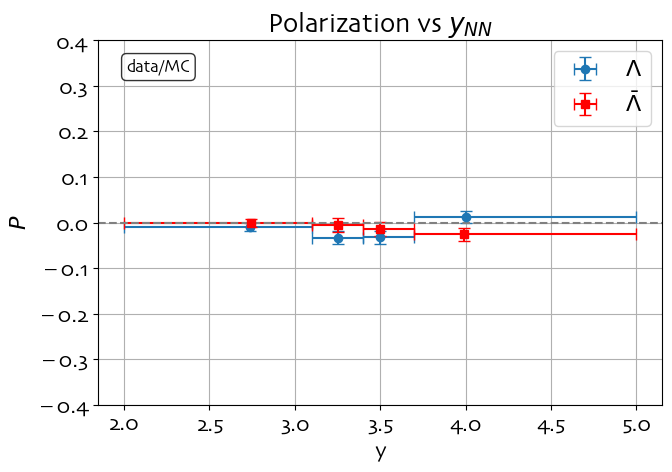

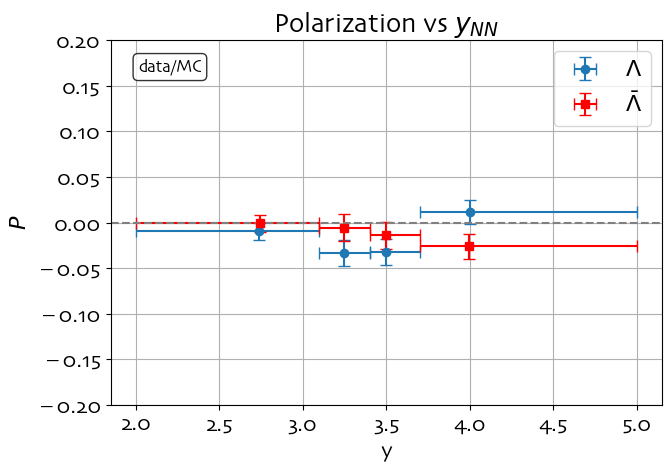

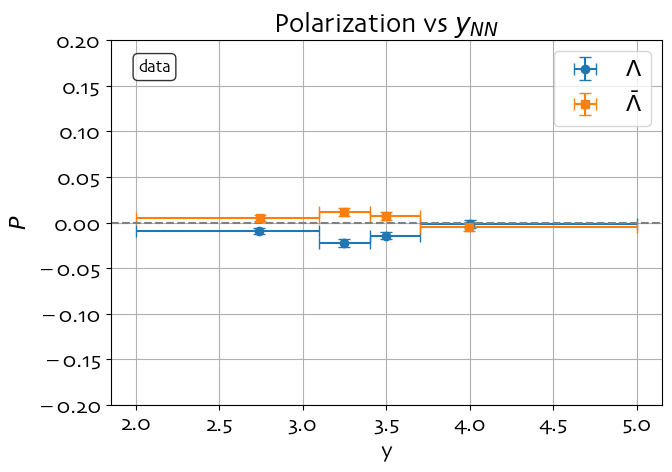

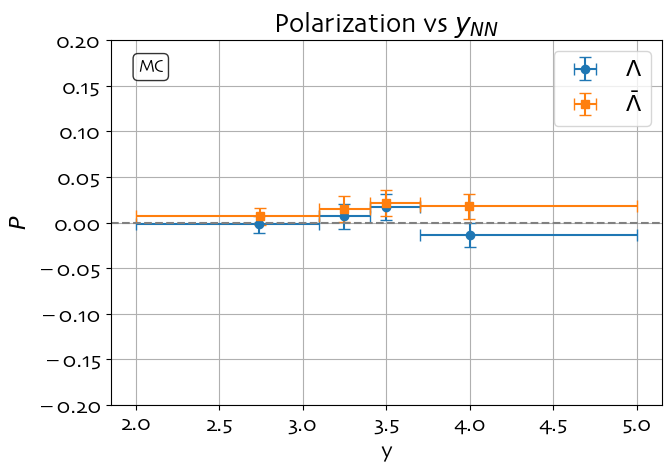

In [120]:

y_centers_al0 = compute_weighted_centers_in_bins(
    filename=path2rootFiles+make_filename('PbPb', 0), 
    histname="Rapidity_0", 
    pt_bins=yNN_bins)
y_centers_l0 = compute_weighted_centers_in_bins(
    filename=path2rootFiles+make_filename('PbPb', 0), 
    histname="Rapidity_1", 
    pt_bins=yNN_bins)

print(y_centers_l0)
pt_centers= y_centers_l0
left_errors = [abs(pt_center - yNN_bins[i]) for i, pt_center in enumerate(pt_centers)]
right_errors = [abs(yNN_bins[i+1] - pt_center) for i, pt_center in enumerate(pt_centers)]
xerr_L = np.array([left_errors, right_errors])  # shape (2, N)

pt_centers= y_centers_al0
left_errors = [abs(pt_center - yNN_bins[i]) for i, pt_center in enumerate(pt_centers)]
right_errors = [abs(yNN_bins[i+1] - pt_center) for i, pt_center in enumerate(pt_centers)]
xerr_aL = np.array([left_errors, right_errors])  # shape (2, N)


fig, ax = plt.subplots(figsize=(7, 5))
# Plot polarization values with error bars
ax.errorbar(y_centers_l0, P_L, xerr=xerr_L, yerr=P_err_L, fmt='o', label=r'$\Lambda$', capsize=4)
ax.errorbar(y_centers_al0, P_aL, xerr=xerr_aL, yerr=P_err_aL, fmt='s', color='red', label=r'$\bar{\Lambda}$', capsize=4)
# Plot horizontal reference line
ax.axhline(0, color='gray', linestyle='--')
# Labels and title
ax.set_xlabel(r'y')
ax.set_ylabel(r'$P$')
ax.set_title(r'Polarization vs $y_{NN}$')
ax.set_ylim(-0.4, 0.4)
ax.grid(True)
ax.legend()
# Add text box in axes coordinates
ax.text(0.05, 0.95, 'data/MC',
        transform=ax.transAxes,
        fontsize=12,
        verticalalignment='top',
        bbox=dict(boxstyle="round", facecolor='white', alpha=0.8))
# Save and show
plt.tight_layout()
plt.savefig("PLOTS_PbPb/Polarization_vs_y_MCcorrected.pdf")
plt.show()

fig, ax = plt.subplots(figsize=(7, 5))
# Plot polarization values with error bars
ax.errorbar(y_centers_l0, P_L, xerr=xerr_L, yerr=P_err_L, fmt='o', label=r'$\Lambda$', capsize=4)
ax.errorbar(y_centers_al0, P_aL, xerr=xerr_aL, yerr=P_err_aL, fmt='s', color='red', label=r'$\bar{\Lambda}$', capsize=4)
# Plot horizontal reference line
ax.axhline(0, color='gray', linestyle='--')
# Labels and title
ax.set_xlabel(r'y')
ax.set_ylabel(r'$P$')
ax.set_title(r'Polarization vs $y_{NN}$')
ax.set_ylim(-0.2, 0.2)
ax.grid(True)
ax.legend()
# Add text box in axes coordinates
ax.text(0.05, 0.95, 'data/MC',
        transform=ax.transAxes,
        fontsize=12,
        verticalalignment='top',
        bbox=dict(boxstyle="round", facecolor='white', alpha=0.8))
# Save and show
plt.tight_layout()
plt.savefig("PLOTS_PbPb/Polarization_vs_y_MCcorrected_zoomed.pdf")
plt.show()

fig, ax = plt.subplots(figsize=(7, 5))
ax.errorbar(y_centers_l0, P_L_noCorr, xerr=xerr_L, yerr=P_err_L_noCorr, fmt='o', label=r'$\Lambda$', capsize=4)
ax.errorbar(y_centers_al0, P_aL_noCorr, xerr=xerr_aL, yerr=P_err_aL_noCorr, fmt='s', label=r'$\bar{\Lambda}$', capsize=4)
# Plot horizontal reference line
ax.axhline(0, color='gray', linestyle='--')
# Labels and title
ax.set_xlabel(r'y')
ax.set_ylabel(r'$P$')
ax.set_title(r'Polarization vs $y_{NN}$')
ax.set_ylim(-0.2, 0.2)
ax.grid(True)
ax.legend()
# Add text box in axes coordinates
ax.text(0.05, 0.95, 'data',
        transform=ax.transAxes,
        fontsize=12,
        verticalalignment='top',
        bbox=dict(boxstyle="round", facecolor='white', alpha=0.8))
plt.tight_layout()
plt.savefig("PLOTS_PbPb/Polarization_vs_y_DatanotCorrected.pdf")
plt.show()

fig, ax = plt.subplots(figsize=(7, 5))
ax.errorbar(y_centers_l0, P_L_noCorrMC, xerr=xerr_L, yerr=P_err_L_noCorrMC, fmt='o', label=r'$\Lambda$', capsize=4)
ax.errorbar(y_centers_al0, P_aL_noCorrMC, xerr=xerr_aL, yerr=P_err_aL_noCorrMC, fmt='s', label=r'$\bar{\Lambda}$', capsize=4)
# Plot horizontal reference line
ax.axhline(0, color='gray', linestyle='--')
# Labels and title
ax.set_xlabel(r'y')
ax.set_ylabel(r'$P$')
ax.set_title(r'Polarization vs $y_{NN}$')
ax.set_ylim(-0.2, 0.2)
ax.grid(True)
ax.legend()
# Add text box in axes coordinates
ax.text(0.05, 0.95, 'MC',
        transform=ax.transAxes,
        fontsize=12,
        verticalalignment='top',
        bbox=dict(boxstyle="round", facecolor='white', alpha=0.8))
plt.tight_layout()
plt.savefig("PLOTS_PbPb/Polarization_vs_y_MCnotCorrected.pdf")
plt.show()

In [121]:
results = MCcorrected_cos_theta_star_inBins(
    filename=path2rootFiles+make_filename('PbPb', 0),
    filename_mc=path2rootFiles+make_filename('PbPb', 1),
    pt_bins=pt_bins,
    BinsOfWhat='pT',
    hist_prefix="CosTheta_",
    save_folder=save_folder,
    alpha_L0=alpha_L0,  # value of alpha for Λ
    system='Pb+Pb'
)
data_notcorrected = cos_theta_star_by_Inbins_ratio(
    filename=path2rootFiles+make_filename('PbPb', 0),
    pt_bins=pt_bins,
    BinsOfWhat='pT',
    hist_prefix="CosTheta_",
    isMC = 0,
    save_folder=save_folder,
    alpha_L0=alpha_L0,  # value of alpha for Λ
    system='Pb+Pb'
)

MC_notcorrected = cos_theta_star_by_Inbins_ratio(
    filename=path2rootFiles+make_filename('PbPb', 1),
    pt_bins=pt_bins,
    BinsOfWhat='pT',
    hist_prefix="CosTheta_",
    isMC =1, 
    save_folder=save_folder,
    alpha_L0=alpha_L0,  # value of alpha for Λ
    system='Pb+Pb'
)


✅ Saved PLOTS_PbPb/cos_theta_star_corrected_pT_Lambda.pdf
✅ Saved PLOTS_PbPb/cos_theta_star_corrected_pT_AntiLambda.pdf
✅ Saved PLOTS_PbPb/ratios_cos_theta_star_pT_Lambda.pdf
✅ Saved PLOTS_PbPb/ratios_cos_theta_star_pT_AntiLambda.pdf
✅ Saved PLOTS_PbPb/ratios_cos_theta_star_pT_Lambda.pdf
✅ Saved PLOTS_PbPb/ratios_cos_theta_star_pT_AntiLambda.pdf


In [122]:
pt_centers_L  = [r[0] for r in results[1]]
P_L           = [r[1] for r in results[1]]
P_err_L       = [r[2] for r in results[1]]
pt_widths_L   = [r[3] for r in results[1]]

pt_centers_aL  = [r[0] for r in results[0]]
P_aL           = [r[1] for r in results[0]]
P_err_aL       = [r[2] for r in results[0]]
pt_widths_aL   = [r[3] for r in results[0]]


pt_centers_L_noCorr  = [r[0] for r in data_notcorrected[1]]
P_L_noCorr           = [r[1] for r in data_notcorrected[1]]
P_err_L_noCorr       = [r[2] for r in data_notcorrected[1]]
pt_widths_L_noCorr   = [r[3] for r in data_notcorrected[1]]

pt_centers_aL_noCorr  = [r[0] for r in data_notcorrected[0]]
P_aL_noCorr           = [r[1] for r in data_notcorrected[0]]
P_err_aL_noCorr       = [r[2] for r in data_notcorrected[0]]
pt_widths_aL_noCorr   = [r[3] for r in data_notcorrected[0]]


pt_centers_L_noCorrMC  = [r[0] for r in MC_notcorrected[1]]
P_L_noCorrMC           = [r[1] for r in MC_notcorrected[1]]
P_err_L_noCorrMC       = [r[2] for r in MC_notcorrected[1]]
pt_widths_L_noCorrMC   = [r[3] for r in MC_notcorrected[1]]

pt_centers_aL_noCorrMC  = [r[0] for r in MC_notcorrected[0]]
P_aL_noCorrMC           = [r[1] for r in MC_notcorrected[0]]
P_err_aL_noCorrMC       = [r[2] for r in MC_notcorrected[0]]
pt_widths_aL_noCorrMC   = [r[3] for r in MC_notcorrected[0]]

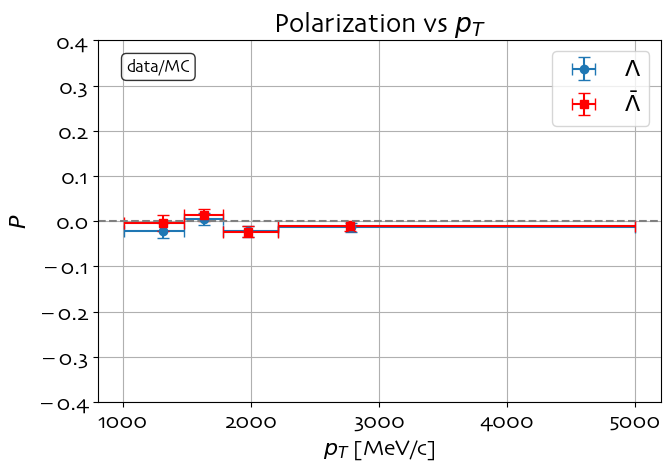

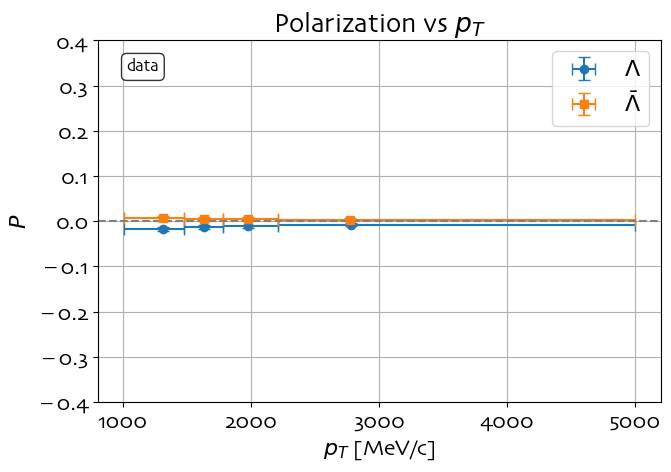

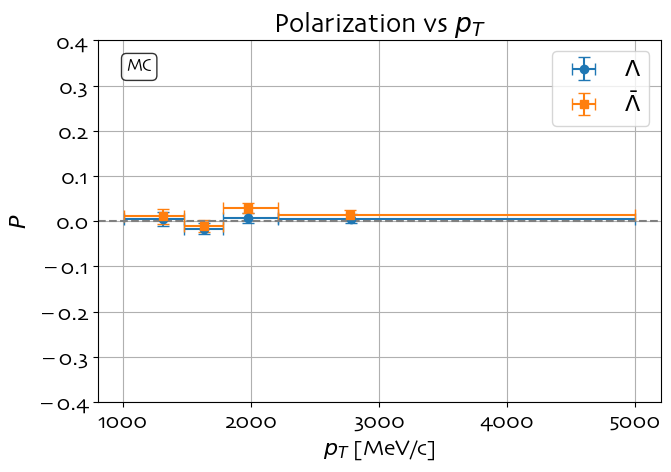

In [123]:

pt_centers_aL = compute_weighted_centers_in_bins(
    filename=path2rootFiles+make_filename('PbPb', 0), 
    histname="LambdaPt_0", 
    pt_bins=pt_bins)
pt_centers_L = compute_weighted_centers_in_bins(
    filename=path2rootFiles+make_filename('PbPb', 0), 
    histname="LambdaPt_1", 
    pt_bins=pt_bins)

pt_centers= pt_centers_L
left_errors = [pt_center - pt_bins[i] for i, pt_center in enumerate(pt_centers)]
right_errors = [pt_bins[i+1] - pt_center for i, pt_center in enumerate(pt_centers)]
xerr_L = np.array([left_errors, right_errors])  # shape (2, N)

pt_centers= pt_centers_aL
left_errors = [pt_center - pt_bins[i] for i, pt_center in enumerate(pt_centers)]
right_errors = [pt_bins[i+1] - pt_center for i, pt_center in enumerate(pt_centers)]
xerr_aL = np.array([left_errors, right_errors])  # shape (2, N)



fig, ax = plt.subplots(figsize=(7, 5))
# Plot polarization values with error bars
ax.errorbar(pt_centers_L, P_L, xerr=xerr_L, yerr=P_err_L, fmt='o', label=r'$\Lambda$', capsize=4)
ax.errorbar(pt_centers_aL, P_aL, xerr=xerr_aL, yerr=P_err_aL, fmt='s', color='red', label=r'$\bar{\Lambda}$', capsize=4)
# Plot horizontal reference line
ax.axhline(0, color='gray', linestyle='--')
# Labels and title
ax.set_xlabel(r'$p_T$ [MeV/c]')
ax.set_ylabel(r'$P$')
ax.set_title('Polarization vs $p_T$')
ax.set_ylim(-0.4, 0.4)
ax.grid(True)
ax.legend()
# Add text box in axes coordinates
ax.text(0.05, 0.95, 'data/MC',
        transform=ax.transAxes,
        fontsize=12,
        verticalalignment='top',
        bbox=dict(boxstyle="round", facecolor='white', alpha=0.8))
# Save and show
plt.tight_layout()
plt.savefig("PLOTS_PbPb/Polarization_vs_pT_MCcorrected.pdf")
plt.show()

fig, ax = plt.subplots(figsize=(7, 5))
ax.errorbar(pt_centers_L, P_L_noCorr, xerr=xerr_L, yerr=P_err_L_noCorr, fmt='o', label=r'$\Lambda$', capsize=4)
ax.errorbar(pt_centers_aL, P_aL_noCorr, xerr=xerr_aL, yerr=P_err_aL_noCorr, fmt='s', label=r'$\bar{\Lambda}$', capsize=4)
# Plot horizontal reference line
ax.axhline(0, color='gray', linestyle='--')
# Labels and title
ax.set_xlabel(r'$p_T$ [MeV/c]')
ax.set_ylabel(r'$P$')
ax.set_title('Polarization vs $p_T$')
ax.set_ylim(-0.4, 0.4)
ax.grid(True)
ax.legend()
# Add text box in axes coordinates
ax.text(0.05, 0.95, 'data',
        transform=ax.transAxes,
        fontsize=12,
        verticalalignment='top',
        bbox=dict(boxstyle="round", facecolor='white', alpha=0.8))
plt.tight_layout()
plt.savefig("PLOTS_PbPb/Polarization_vs_pT_DatanotCorrected.pdf")
plt.show()

fig, ax = plt.subplots(figsize=(7, 5))
ax.errorbar(pt_centers_L, P_L_noCorrMC, xerr=xerr_L, yerr=P_err_L_noCorrMC, fmt='o', label=r'$\Lambda$', capsize=4)
ax.errorbar(pt_centers_aL, P_aL_noCorrMC, xerr=xerr_aL, yerr=P_err_aL_noCorrMC, fmt='s', label=r'$\bar{\Lambda}$', capsize=4)
# Plot horizontal reference line
ax.axhline(0, color='gray', linestyle='--')
# Labels and title
ax.set_xlabel(r'$p_T$ [MeV/c]')
ax.set_ylabel(r'$P$')
ax.set_title('Polarization vs $p_T$')
ax.set_ylim(-0.4, 0.4)
ax.grid(True)
ax.legend()
# Add text box in axes coordinates
ax.text(0.05, 0.95, 'MC',
        transform=ax.transAxes,
        fontsize=12,
        verticalalignment='top',
        bbox=dict(boxstyle="round", facecolor='white', alpha=0.8))
plt.tight_layout()
plt.savefig("PLOTS_PbPb/Polarization_vs_pT_MCnotCorrected.pdf")
plt.show()

In [124]:
xf_results = MCcorrected_cos_theta_star_inBins(
    filename=path2rootFiles+make_filename('PbPb', 0),
    filename_mc=path2rootFiles+make_filename('PbPb', 1),
    pt_bins=xF_bins,
    BinsOfWhat='xF',
    hist_prefix="CosTheta_",
    save_folder=save_folder,
    alpha_L0=alpha_L0,  # value of alpha for Λ
    system='Pb+Pb'
)
xf_data_notcorrected = cos_theta_star_by_Inbins_ratio(
    filename=path2rootFiles+make_filename('PbPb', 0),
    pt_bins=xF_bins,
    BinsOfWhat='xF',
    hist_prefix="CosTheta_",
    isMC = 0,
    save_folder=save_folder,
    alpha_L0=alpha_L0,  # value of alpha for Λ
    system='Pb+Pb'
)

xf_MC_notcorrected = cos_theta_star_by_Inbins_ratio(
    filename=path2rootFiles+make_filename('PbPb', 1),
    pt_bins=xF_bins,
    BinsOfWhat='xF',
    hist_prefix="CosTheta_",
    isMC = 1, 
    save_folder=save_folder,
    alpha_L0=alpha_L0,  # value of alpha for Λ
    system='Pb+Pb'
)


✅ Saved PLOTS_PbPb/cos_theta_star_corrected_xF_Lambda.pdf
✅ Saved PLOTS_PbPb/cos_theta_star_corrected_xF_AntiLambda.pdf
✅ Saved PLOTS_PbPb/ratios_cos_theta_star_xF_Lambda.pdf
✅ Saved PLOTS_PbPb/ratios_cos_theta_star_xF_AntiLambda.pdf
✅ Saved PLOTS_PbPb/ratios_cos_theta_star_xF_Lambda.pdf
✅ Saved PLOTS_PbPb/ratios_cos_theta_star_xF_AntiLambda.pdf


In [125]:
pt_centers_L  = [r[0] for r in xf_results[1]]
P_L           = [r[1] for r in xf_results[1]]
P_err_L       = [r[2] for r in xf_results[1]]
pt_widths_L   = [r[3] for r in xf_results[1]]

pt_centers_aL  = [r[0] for r in xf_results[0]]
P_aL           = [r[1] for r in xf_results[0]]
P_err_aL       = [r[2] for r in xf_results[0]]
pt_widths_aL   = [r[3] for r in xf_results[0]]


pt_centers_L_noCorr  = [r[0] for r in xf_data_notcorrected[1]]
P_L_noCorr           = [r[1] for r in xf_data_notcorrected[1]]
P_err_L_noCorr       = [r[2] for r in xf_data_notcorrected[1]]
pt_widths_L_noCorr   = [r[3] for r in xf_data_notcorrected[1]]

pt_centers_aL_noCorr  = [r[0] for r in xf_data_notcorrected[0]]
P_aL_noCorr           = [r[1] for r in xf_data_notcorrected[0]]
P_err_aL_noCorr       = [r[2] for r in xf_data_notcorrected[0]]
pt_widths_aL_noCorr   = [r[3] for r in xf_data_notcorrected[0]]


pt_centers_L_noCorrMC  = [r[0] for r in xf_MC_notcorrected[1]]
P_L_noCorrMC           = [r[1] for r in xf_MC_notcorrected[1]]
P_err_L_noCorrMC       = [r[2] for r in xf_MC_notcorrected[1]]
pt_widths_L_noCorrMC   = [r[3] for r in xf_MC_notcorrected[1]]

pt_centers_aL_noCorrMC  = [r[0] for r in xf_MC_notcorrected[0]]
P_aL_noCorrMC           = [r[1] for r in xf_MC_notcorrected[0]]
P_err_aL_noCorrMC       = [r[2] for r in xf_MC_notcorrected[0]]
pt_widths_aL_noCorrMC   = [r[3] for r in xf_MC_notcorrected[0]]

[np.float64(0.001), 0, 0, np.float64(0.011814453456408865)]


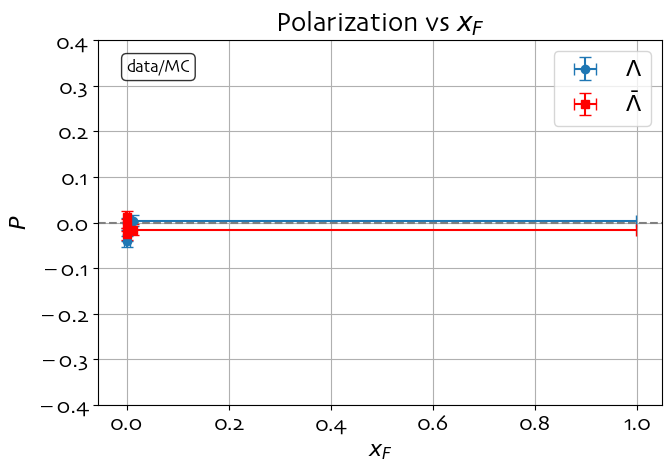

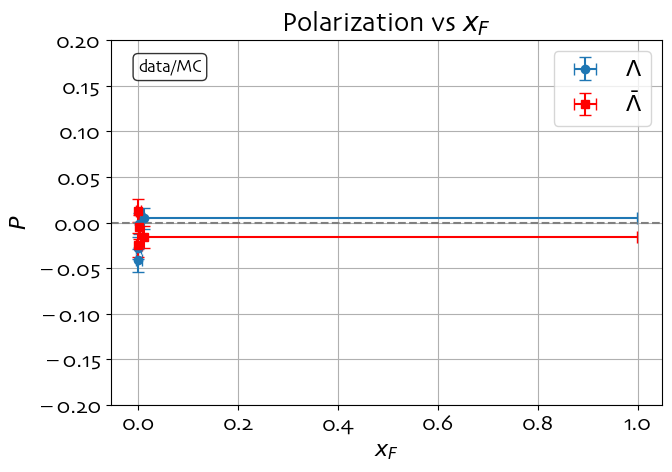

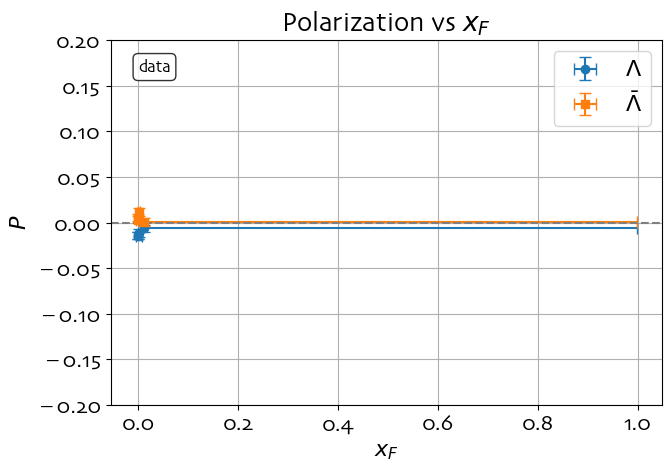

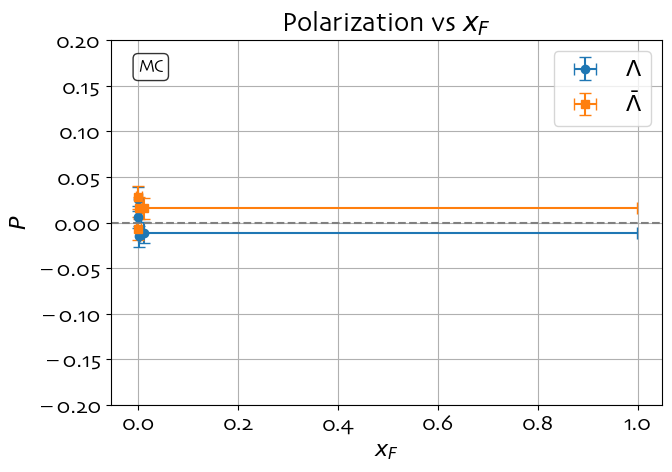

In [126]:

xf_centers_al0 = compute_weighted_centers_in_bins(
    filename=path2rootFiles+make_filename('PbPb', 0), 
    histname="LambdaXf_0", 
    pt_bins=xF_bins)
xf_centers_l0 = compute_weighted_centers_in_bins(
    filename=path2rootFiles+make_filename('PbPb', 0), 
    histname="LambdaXf_1", 
    pt_bins=xF_bins)
print(xf_centers_l0)

pt_centers= xf_centers_l0
left_errors = [abs(pt_center - xF_bins[i]) for i, pt_center in enumerate(pt_centers)]
right_errors = [abs(xF_bins[i+1] - pt_center) for i, pt_center in enumerate(pt_centers)]
xerr_L = np.array([left_errors, right_errors])  # shape (2, N)

pt_centers= xf_centers_al0
left_errors = [abs(pt_center - xF_bins[i]) for i, pt_center in enumerate(pt_centers)]
right_errors = [abs(xF_bins[i+1] - pt_center) for i, pt_center in enumerate(pt_centers)]
xerr_aL = np.array([left_errors, right_errors])  # shape (2, N)


fig, ax = plt.subplots(figsize=(7, 5))
# Plot polarization values with error bars
ax.errorbar(xf_centers_l0, P_L, xerr=xerr_L, yerr=P_err_L, fmt='o', label=r'$\Lambda$', capsize=4)
ax.errorbar(xf_centers_al0, P_aL, xerr=xerr_aL, yerr=P_err_aL, fmt='s', color='red', label=r'$\bar{\Lambda}$', capsize=4)
# Plot horizontal reference line
ax.axhline(0, color='gray', linestyle='--')
# Labels and title
ax.set_xlabel(r'$x_F$ ')
ax.set_ylabel(r'$P$')
ax.set_title('Polarization vs $x_F$')
ax.set_ylim(-0.4, 0.4)
ax.grid(True)
ax.legend()
# Add text box in axes coordinates
ax.text(0.05, 0.95, 'data/MC',
        transform=ax.transAxes,
        fontsize=12,
        verticalalignment='top',
        bbox=dict(boxstyle="round", facecolor='white', alpha=0.8))
# Save and show
plt.tight_layout()
plt.savefig("PLOTS_PbPb/Polarization_vs_xF_MCcorrected.pdf")
plt.show()

fig, ax = plt.subplots(figsize=(7, 5))
# Plot polarization values with error bars
ax.errorbar(xf_centers_l0, P_L, xerr=xerr_L, yerr=P_err_L, fmt='o', label=r'$\Lambda$', capsize=4)
ax.errorbar(xf_centers_al0, P_aL, xerr=xerr_aL, yerr=P_err_aL, fmt='s', color='red', label=r'$\bar{\Lambda}$', capsize=4)
# Plot horizontal reference line
ax.axhline(0, color='gray', linestyle='--')
# Labels and title
ax.set_xlabel(r'$x_F$ ')
ax.set_ylabel(r'$P$')
ax.set_title('Polarization vs $x_F$')
ax.set_ylim(-0.2, 0.2)
ax.grid(True)
ax.legend()
# Add text box in axes coordinates
ax.text(0.05, 0.95, 'data/MC',
        transform=ax.transAxes,
        fontsize=12,
        verticalalignment='top',
        bbox=dict(boxstyle="round", facecolor='white', alpha=0.8))
# Save and show
plt.tight_layout()
plt.savefig("PLOTS_PbPb/Polarization_vs_xF_MCcorrected_zoom.pdf")
plt.show()

fig, ax = plt.subplots(figsize=(7, 5))
ax.errorbar(xf_centers_l0, P_L_noCorr, xerr=xerr_L, yerr=P_err_L_noCorr, fmt='o', label=r'$\Lambda$', capsize=4)
ax.errorbar(xf_centers_al0, P_aL_noCorr, xerr=xerr_aL, yerr=P_err_aL_noCorr, fmt='s', label=r'$\bar{\Lambda}$', capsize=4)
# Plot horizontal reference line
ax.axhline(0, color='gray', linestyle='--')
# Labels and title
ax.set_xlabel(r'$x_F$ ')
ax.set_ylabel(r'$P$')
ax.set_title('Polarization vs $x_F$')
ax.set_ylim(-0.2, 0.2)
ax.grid(True)
ax.legend()
# Add text box in axes coordinates
ax.text(0.05, 0.95, 'data',
        transform=ax.transAxes,
        fontsize=12,
        verticalalignment='top',
        bbox=dict(boxstyle="round", facecolor='white', alpha=0.8))
plt.tight_layout()
plt.savefig("PLOTS_PbPb/Polarization_vs_xF_DatanotCorrected.pdf")
plt.show()

fig, ax = plt.subplots(figsize=(7, 5))
ax.errorbar(xf_centers_l0, P_L_noCorrMC, xerr=xerr_L, yerr=P_err_L_noCorrMC, fmt='o', label=r'$\Lambda$', capsize=4)
ax.errorbar(xf_centers_al0, P_aL_noCorrMC, xerr=xerr_aL, yerr=P_err_aL_noCorrMC, fmt='s', label=r'$\bar{\Lambda}$', capsize=4)
# Plot horizontal reference line
ax.axhline(0, color='gray', linestyle='--')
# Labels and title
ax.set_xlabel(r'$x_F$ ')
ax.set_ylabel(r'$P$')
ax.set_title('Polarization vs $x_F$')
ax.set_ylim(-0.2, 0.2)
ax.grid(True)
ax.legend()
# Add text box in axes coordinates
ax.text(0.05, 0.95, 'MC',
        transform=ax.transAxes,
        fontsize=12,
        verticalalignment='top',
        bbox=dict(boxstyle="round", facecolor='white', alpha=0.8))
plt.tight_layout()
plt.savefig("PLOTS_PbPb/Polarization_vs_xF_MCnotCorrected.pdf")
plt.show()

<>:81: SyntaxWarning: invalid escape sequence '\L'
<>:81: SyntaxWarning: invalid escape sequence '\L'
/var/folders/n_/wmbdlzd17s7gcyvkql_0tn3c0000gq/T/ipykernel_54964/536340343.py:81: SyntaxWarning: invalid escape sequence '\L'
  '''


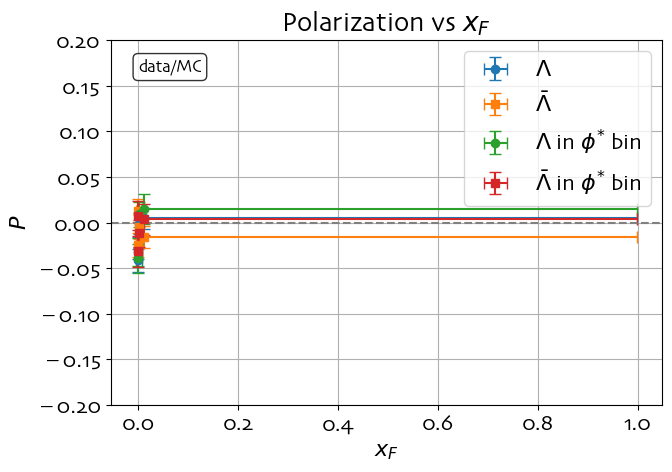

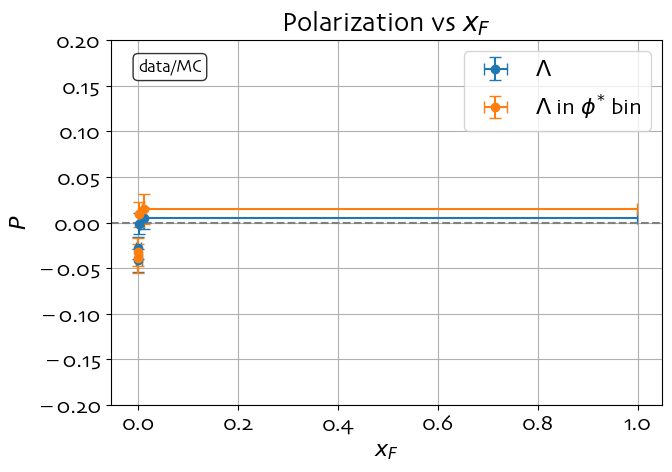

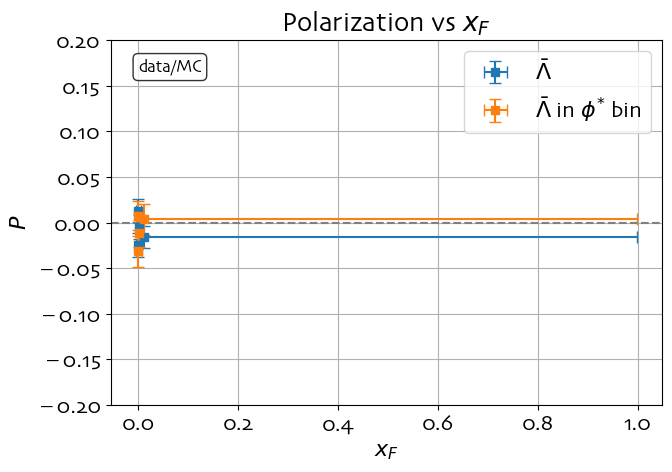

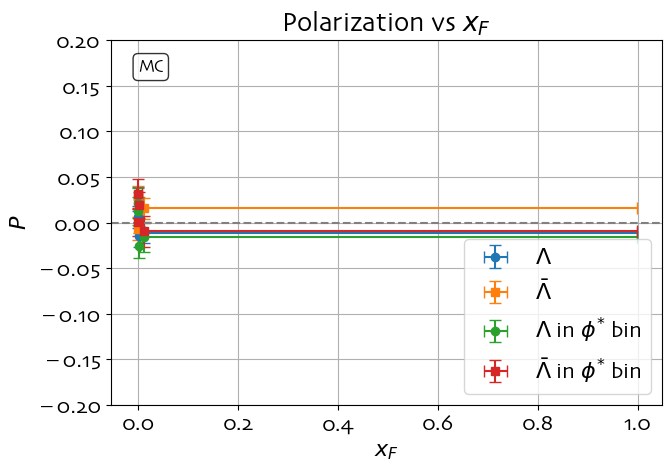

In [127]:
fig, ax = plt.subplots(figsize=(7, 5))
# Plot polarization values with error bars
ax.errorbar(xf_centers_l0, P_L, xerr=xerr_L, yerr=P_err_L, fmt='o', label=r'$\Lambda$', capsize=4)
ax.errorbar(xf_centers_al0, P_aL, xerr=xerr_aL, yerr=P_err_aL, fmt='s',  label=r'$\bar{\Lambda}$', capsize=4)
ax.errorbar(xf_centers_l0, phi_P_L, xerr=xerr_L, yerr=phi_P_err_L, fmt='o', label=r'$\Lambda$ in $\phi^{*}$ bin', capsize=4)
ax.errorbar(xf_centers_al0, phi_P_aL, xerr=xerr_aL, yerr=phi_P_err_aL, fmt='s',label=r'$\bar{\Lambda}$ in $\phi^{*}$ bin', capsize=4)
# Plot horizontal reference line
ax.axhline(0, color='gray', linestyle='--')
# Labels and title
ax.set_xlabel(r'$x_F$ ')
ax.set_ylabel(r'$P$')
ax.set_title('Polarization vs $x_F$')
ax.set_ylim(-0.2, 0.2)
ax.grid(True)
ax.legend()
# Add text box in axes coordinates
ax.text(0.05, 0.95, 'data/MC',
        transform=ax.transAxes,
        fontsize=12,
        verticalalignment='top',
        bbox=dict(boxstyle="round", facecolor='white', alpha=0.8))
# Save and show
plt.tight_layout()
plt.savefig("PLOTS_PbPb/Comparison_Polarization_vs_xF_MCcorrected.pdf")
plt.show()


fig, ax = plt.subplots(figsize=(7, 5))
# Plot polarization values with error bars
ax.errorbar(xf_centers_l0, P_L, xerr=xerr_L, yerr=P_err_L, fmt='o', label=r'$\Lambda$', capsize=4)
#ax.errorbar(pt_centers_aL, P_aL, xerr=pt_widths_aL, yerr=P_err_aL, fmt='s',  label=r'$\bar{\Lambda}$', capsize=4)
ax.errorbar(xf_centers_l0, phi_P_L, xerr=xerr_L, yerr=phi_P_err_L, fmt='o', label=r'$\Lambda$ in $\phi^{*}$ bin', capsize=4)
#ax.errorbar(phi_pt_centers_aL, phi_P_aL, xerr=phi_pt_widths_aL, yerr=phi_P_err_aL, fmt='s',label=r'$\bar{\Lambda}$ in $\phi^{*}$ bin', capsize=4)
# Plot horizontal reference line
ax.axhline(0, color='gray', linestyle='--')
# Labels and title
ax.set_xlabel(r'$x_F$ ')
ax.set_ylabel(r'$P$')
ax.set_title('Polarization vs $x_F$')
ax.set_ylim(-0.2, 0.2)
ax.grid(True)
ax.legend()
# Add text box in axes coordinates
ax.text(0.05, 0.95, 'data/MC',
        transform=ax.transAxes,
        fontsize=12,
        verticalalignment='top',
        bbox=dict(boxstyle="round", facecolor='white', alpha=0.8))
# Save and show
plt.tight_layout()
plt.savefig("PLOTS_PbPb/Comparison_Polarization_vs_xF_MCcorrected_L0.pdf")
plt.show()

fig, ax = plt.subplots(figsize=(7, 5))
# Plot polarization values with error bars
#ax.errorbar(pt_centers_L, P_L, xerr=pt_widths_L, yerr=P_err_L, fmt='o', label=r'$\Lambda$', capsize=4)
ax.errorbar(xf_centers_al0, P_aL, xerr=xerr_aL, yerr=P_err_aL, fmt='s',  label=r'$\bar{\Lambda}$', capsize=4)
#ax.errorbar(phi_pt_centers_L, phi_P_L, xerr=phi_pt_widths_L, yerr=phi_P_err_L, fmt='o', label=r'$\Lambda$ in $\phi^{*}$ bin', capsize=4)
ax.errorbar(xf_centers_al0, phi_P_aL, xerr=xerr_aL, yerr=phi_P_err_aL, fmt='s',label=r'$\bar{\Lambda}$ in $\phi^{*}$ bin', capsize=4)
# Plot horizontal reference line
ax.axhline(0, color='gray', linestyle='--')
# Labels and title
ax.set_xlabel(r'$x_F$ ')
ax.set_ylabel(r'$P$')
ax.set_title('Polarization vs $x_F$')
ax.set_ylim(-0.2, 0.2)
ax.grid(True)
ax.legend()
# Add text box in axes coordinates
ax.text(0.05, 0.95, 'data/MC',
        transform=ax.transAxes,
        fontsize=12,
        verticalalignment='top',
        bbox=dict(boxstyle="round", facecolor='white', alpha=0.8))
# Save and show
plt.tight_layout()
plt.savefig("PLOTS_PbPb/Comparison_Polarization_vs_xF_MCcorrected_AL0.pdf")
plt.show()


'''
fig, ax = plt.subplots(figsize=(7, 5))
# Plot polarization values with error bars
ax.errorbar(pt_centers_L, P_L, xerr=pt_widths_L, yerr=P_err_L, fmt='o', label=r'$\Lambda$', capsize=4)
ax.errorbar(pt_centers_aL, P_aL, xerr=pt_widths_aL, yerr=P_err_aL, fmt='s', color='red', label=r'$\bar{\Lambda}$', capsize=4)
# Plot horizontal reference line
ax.axhline(0, color='gray', linestyle='--')
# Labels and title
ax.set_xlabel(r'$x_F$ ')
ax.set_ylabel(r'$P$')
ax.set_title('Polarization vs $x_F$')
ax.set_ylim(-0.2, 0.2)
ax.grid(True)
ax.legend()
# Add text box in axes coordinates
ax.text(0.05, 0.95, 'data/MC',
        transform=ax.transAxes,
        fontsize=12,
        verticalalignment='top',
        bbox=dict(boxstyle="round", facecolor='white', alpha=0.8))
# Save and show
plt.tight_layout()
plt.savefig("PLOTS_PbPb/Polarization_vs_xF_MCcorrected_zoom.pdf")
plt.show()

fig, ax = plt.subplots(figsize=(7, 5))
ax.errorbar(pt_centers_L_noCorr, P_L_noCorr, xerr=pt_widths_L_noCorr, yerr=P_err_L_noCorr, fmt='o', label=r'$\Lambda$', capsize=4)
ax.errorbar(pt_centers_aL, P_aL_noCorr, xerr=pt_widths_aL_noCorr, yerr=P_err_aL_noCorr, fmt='s', label=r'$\bar{\Lambda}$', capsize=4)
# Plot horizontal reference line
ax.axhline(0, color='gray', linestyle='--')
# Labels and title
ax.set_xlabel(r'$x_F$ ')
ax.set_ylabel(r'$P$')
ax.set_title('Polarization vs $x_F$')
ax.set_ylim(-0.2, 0.2)
ax.grid(True)
ax.legend()
# Add text box in axes coordinates
ax.text(0.05, 0.95, 'data',
        transform=ax.transAxes,
        fontsize=12,
        verticalalignment='top',
        bbox=dict(boxstyle="round", facecolor='white', alpha=0.8))
plt.tight_layout()
plt.savefig("PLOTS_PbPb/Polarization_vs_xF_DatanotCorrected.pdf")
plt.show()
'''


fig, ax = plt.subplots(figsize=(7, 5))
ax.errorbar(xf_centers_l0, P_L_noCorrMC, xerr=xerr_L, yerr=P_err_L_noCorrMC, fmt='o', label=r'$\Lambda$', capsize=4)
ax.errorbar(xf_centers_al0, P_aL_noCorrMC, xerr=xerr_aL, yerr=P_err_aL_noCorrMC, fmt='s', label=r'$\bar{\Lambda}$', capsize=4)

ax.errorbar(xf_centers_l0, phi_P_L_noCorrMC, xerr=xerr_L, yerr=phi_P_err_L_noCorrMC, fmt='o', label=r'$\Lambda$ in $\phi^{*}$ bin', capsize=4)
ax.errorbar(xf_centers_al0, phi_P_aL_noCorrMC, xerr=xerr_aL, yerr=phi_P_err_aL_noCorrMC, fmt='s', label=r'$\bar{\Lambda}$ in $\phi^{*}$ bin', capsize=4)

# Plot horizontal reference line
ax.axhline(0, color='gray', linestyle='--')
# Labels and title
ax.set_xlabel(r'$x_F$ ')
ax.set_ylabel(r'$P$')
ax.set_title('Polarization vs $x_F$')
ax.set_ylim(-0.2, 0.2)
ax.grid(True)
ax.legend()
# Add text box in axes coordinates
ax.text(0.05, 0.95, 'MC',
        transform=ax.transAxes,
        fontsize=12,
        verticalalignment='top',
        bbox=dict(boxstyle="round", facecolor='white', alpha=0.8))
plt.tight_layout()
plt.savefig("PLOTS_PbPb/Comparison_Polarization_vs_xF_MCnotCorrected.pdf")
plt.show()


In [128]:
def MCcorrected2D_cos_theta_star_inBins(
    filename, filename_mc, pt_bins,
    BinsOfWhat,
    hist_prefix="PhiStarCosThetaStar_",
    save_folder="PLOTS_PbPb",
    system = "default",
    alpha_L0=0.732,
):
    os.makedirs(save_folder, exist_ok=True)
    file_data = uproot.open(filename)
    file_mc = uproot.open(filename_mc)

    all_P_results = {1: [], 0: []}

    for particle_id in [1, 0]:
        fig, axes = plt.subplots(2, len(pt_bins) - 1, figsize=(8 * (len(pt_bins) - 1), 10))

        particle_label = r"Lambda" if particle_id == 1 else r"AntiLambda"

        for i in range(len(pt_bins) - 1):
            histname_ = f"{hist_prefix}{particle_id}_{BinsOfWhat}{i}"
            if histname_ not in file_data or histname_ not in file_mc:
                print(f"Missing histogram: {histname_}")
                continue

            values_data, x_edges, y_edges = file_data[histname_].to_numpy()
            values_mc, _, _= file_mc[histname_].to_numpy()
            
            errors_data = np.sqrt(values_data)
            errors_mc = np.sqrt(values_mc)


            # Create a boolean mask for x between 2.8 and 4.8
           # mask = (x_bin_centers >= 2.8) & (x_bin_centers <= 4.8)

            # Step 2: Select columns that match the mask
          #  selected_values = values[:, mask]  # Select all rows but only columns in 2.8-4.8

            # Step 3: Find the minimum value among the selected bins
          # min_value = np.min(selected_values)


            print('The lowest entries in the bin data: ', values_data.min())
            print('The lowest entries in the bin MC: ', values_mc.min())
            # Normalize each column (i.e., along axis=0)
            with np.errstate(divide='ignore', invalid='ignore'):
                col_sums_data = values_data.sum(axis=0)
                col_sums_MC = values_mc.sum(axis=0)

                # Avoid division by zero
                norm_data = np.divide(values_data, col_sums_data, where=col_sums_data > 0)
                norm_MC = np.divide(values_mc, col_sums_MC, where=col_sums_MC > 0)

                # Propagate errors for normalized values: σ_norm = σ_orig / sum
                norm_errors_data = np.divide(errors_data, col_sums_data, where=col_sums_data > 0)
                norm_errors_MC = np.divide(errors_mc, col_sums_MC, where=col_sums_MC > 0)

            #Normalization:
            #total_data = np.sum(values_data)
            #if total_data > 0:
            #    values_data /= total_data
            #    errors_data /= total_data

            #total_MC = np.sum(values_mc)
            #if total_MC > 0:
            #    values_mc /= total_MC
            #    errors_mc /= total_MC

            values_data = norm_data
            errors_data = norm_errors_data

            values_mc = norm_MC
            errors_mc = norm_errors_MC


            pt_min, pt_max = pt_bins[i], pt_bins[i + 1]
            y_centers = 0.5 * (y_edges[:-1] + y_edges[1:])
            x_centers = 0.5 * (x_edges[:-1] + x_edges[1:])
           
            ## ratio ## 
            ratio = np.divide(values_data, values_mc, out=np.zeros_like(values_data), where=values_mc != 0)
            # First create masks to avoid division by zero
            valid = (values_data > 0) & (values_mc > 0)
            # Initialize errors with zeros
            ratio_err = np.zeros_like(ratio)
            # Compute error only for valid bins
            ratio_err[valid] = ratio[valid] * np.sqrt(
                (errors_data[valid] / values_data[valid])**2 +
                (errors_mc[valid] / values_mc[valid])**2
            )

            # projection over phi*
           # nrbins_ratio = np.sum((x_centers > 2.8) & (x_centers < 4.8))
            # First get the mask of valid x bins
            x_mask = (x_edges[:-1] > 2.8) & (x_edges[1:] < 4.8)
            print(ratio[x_mask])
            num_bins_summed = np.count_nonzero(x_mask)
            # Apply the mask to select rows, then sum over those
            projection_y = ratio[x_mask, :].sum(axis=0)/num_bins_summed
            print(ratio[x_mask, :])
            print(num_bins_summed)
           # projection_y = ratio.sum(axis=0)/nrbins_ratio
            projection_y_err = np.sqrt(np.sum(ratio_err[x_mask, :]**2, axis=0))/num_bins_summed
            
            ax_top = axes[0, i]
            pcm = ax_top.pcolormesh(x_edges, y_edges, values_data.T, shading='auto', cmap='viridis')
            ax_top.set_title(fr"${pt_min:.2f} < {BinsOfWhat} < {pt_max:.2f}$")
            ax_top.set_ylabel(r"$\cos \theta^{*}$")
            ax_top.set_xlabel(r"$\phi^{*}$")
         #   fig.colorbar(pcm, ax_top=ax_top, label='Counts')

            ax_bot = axes[1, i]
            ax_bot.errorbar(y_centers, projection_y, yerr=projection_y_err, fmt="o", capsize=3, color="blue")
            ax_bot.axhline(1, color="red", linestyle="--")
            ax_bot.set_xlabel(r"$\cos \theta^{*}$")
            ax_bot.set_ylabel("Data / MC")
            ax_bot.set_ylim(0.8, 1.2)
            ax_bot.grid(True)

            alpha = alpha_L0 if particle_id == 1 else -alpha_L0
            try:
                popt, pcov = curve_fit(lambda x, P: 1 + alpha * P * x, y_centers, projection_y, sigma=projection_y_err, absolute_sigma=True)
                P_fit = popt[0]
                P_err = np.sqrt(pcov[0][0])
                fit_line = 1 + alpha * P_fit * y_centers
                ax_bot.plot(y_centers, fit_line, linestyle="--", color="green")
                textstr = f"{system}: {particle_label}\n$P = {P_fit:.3f} \pm {P_err:.3f}$\n$\\alpha = {alpha:.3f}$"
                ax_bot.text(0.05, 0.95, textstr, transform=ax_bot.transAxes,
                            fontsize=12, verticalalignment='top',
                            bbox=dict(boxstyle="round", facecolor='white', alpha=0.8))
            except Exception as e:
                print(f"⚠️ Fit failed for particle {particle_id}, {BinsOfWhat} bin {pt_min}-{pt_max}: {e}")
                P_fit = np.nan
                P_err = np.nan

            pt_center = 0.5 * (pt_min + pt_max)
            pt_width = 0.5 * (pt_max - pt_min)
            all_P_results[particle_id].append((pt_center, P_fit, P_err, pt_width))

        
        fig.suptitle(fr"Cos($\theta^*$) Comparison for ${particle_label}$ in ${BinsOfWhat}", fontsize=16)
        plt.tight_layout(rect=[0, 0, 1, 0.95])
        outname = os.path.join(save_folder, f"cos_theta_2DCorrection_{BinsOfWhat}_{particle_label}.pdf")
        plt.savefig(outname)
        print(f"✅ Saved {outname}")
        plt.show()
        plt.close(fig)

    return all_P_results


<>:127: SyntaxWarning: invalid escape sequence '\p'
<>:127: SyntaxWarning: invalid escape sequence '\p'
/var/folders/n_/wmbdlzd17s7gcyvkql_0tn3c0000gq/T/ipykernel_54964/1354776334.py:127: SyntaxWarning: invalid escape sequence '\p'
  textstr = f"{system}: {particle_label}\n$P = {P_fit:.3f} \pm {P_err:.3f}$\n$\\alpha = {alpha:.3f}$"


In [129]:
save_folder = "PLOTS_PbPb/phi"
def make_filename(system, isMC):
    filetype = 'MC' if isMC else 'data'
    filename = f'Polarization_{system}_{filetype}_L0_AL0_phi.root'
    return filename

The lowest entries in the bin data:  0.0
The lowest entries in the bin MC:  0.0
[[0.94713011 0.96918566 1.07289225 1.09961365 1.14658101 1.12936806
  0.97876684 1.08176848 1.00092723 0.9863262 ]
 [1.02364649 1.02479688 1.04019311 1.07410311 1.033276   1.08648672
  1.07138119 1.0339062  1.08962534 1.12689825]
 [1.03035021 1.05938876 1.03754229 1.06503158 1.04242149 1.07450038
  1.12479275 1.02600622 1.00825775 1.04888778]
 [1.0299844  1.01899463 0.99777911 1.00824507 1.01275422 0.99128945
  0.97903753 1.02179101 1.01912227 0.99087268]
 [1.02782655 0.96514531 0.98563601 0.89473035 0.97943703 0.92804503
  0.93305544 0.96410454 0.96909547 0.96950244]
 [0.91867119 0.92091099 0.78608801 0.81849592 0.80769166 0.8282232
  0.83882782 0.77179571 0.88335271 0.77599545]]
[[0.94713011 0.96918566 1.07289225 1.09961365 1.14658101 1.12936806
  0.97876684 1.08176848 1.00092723 0.9863262 ]
 [1.02364649 1.02479688 1.04019311 1.07410311 1.033276   1.08648672
  1.07138119 1.0339062  1.08962534 1.12689825]


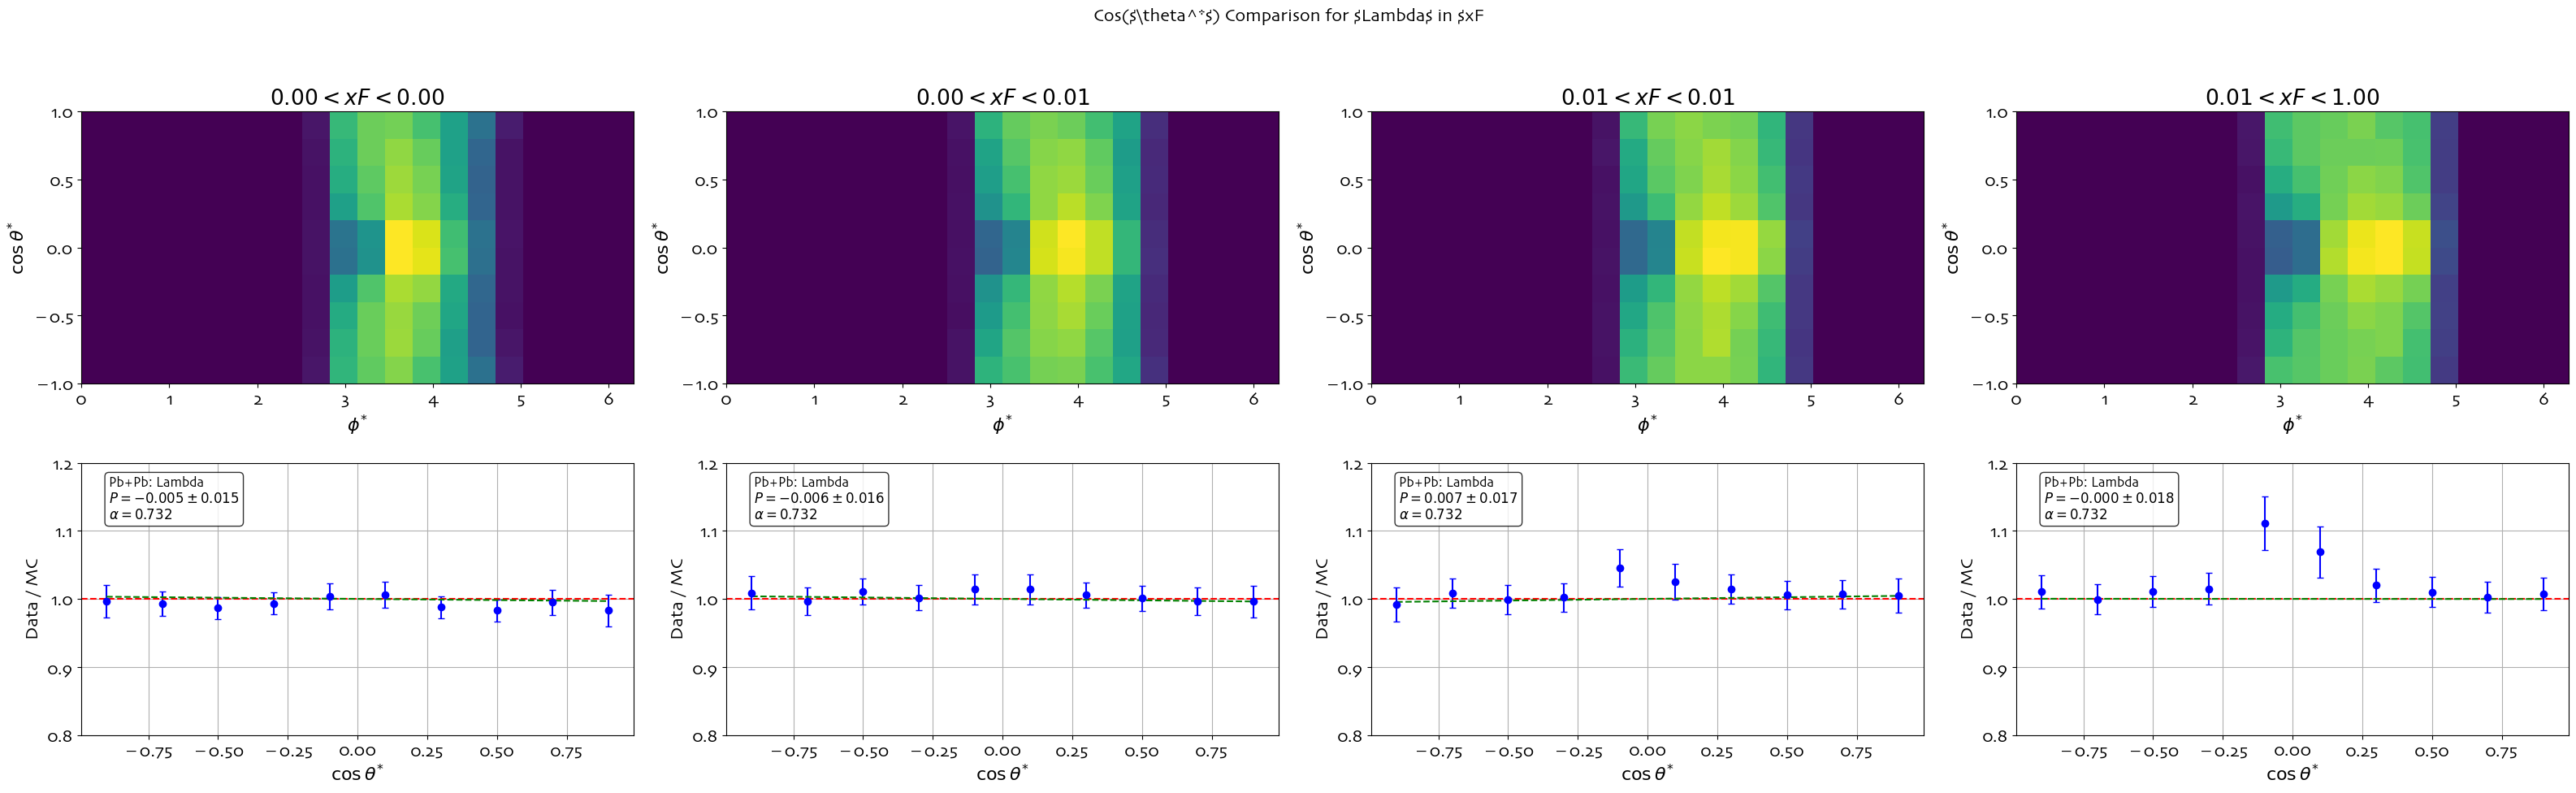

The lowest entries in the bin data:  0.0
The lowest entries in the bin MC:  0.0
[[1.06351707 1.00750971 1.0111023  1.07174385 1.21494852 0.99618305
  1.13818494 1.06617403 1.10567332 1.15660077]
 [1.004442   1.06941737 1.01258313 1.05276606 1.15665499 1.09557645
  1.06052221 1.03574303 1.03811755 1.02524004]
 [1.0767627  0.98293527 1.08092729 1.05695286 1.00109503 1.01813387
  0.99057456 1.03637107 0.99806733 0.97854205]
 [1.02924236 1.08848852 1.00051071 0.95239478 1.00147896 1.06141184
  0.98380396 0.93060637 1.06036017 0.95149974]
 [0.98111238 0.96333227 0.99162327 0.97680808 0.92107899 0.96572888
  0.9440926  0.9987709  0.92725932 0.94922862]
 [0.81916658 0.86008853 0.86237882 0.85529703 0.83778439 0.84438848
  0.8875807  0.91272453 0.82910822 0.94739865]]
[[1.06351707 1.00750971 1.0111023  1.07174385 1.21494852 0.99618305
  1.13818494 1.06617403 1.10567332 1.15660077]
 [1.004442   1.06941737 1.01258313 1.05276606 1.15665499 1.09557645
  1.06052221 1.03574303 1.03811755 1.02524004]

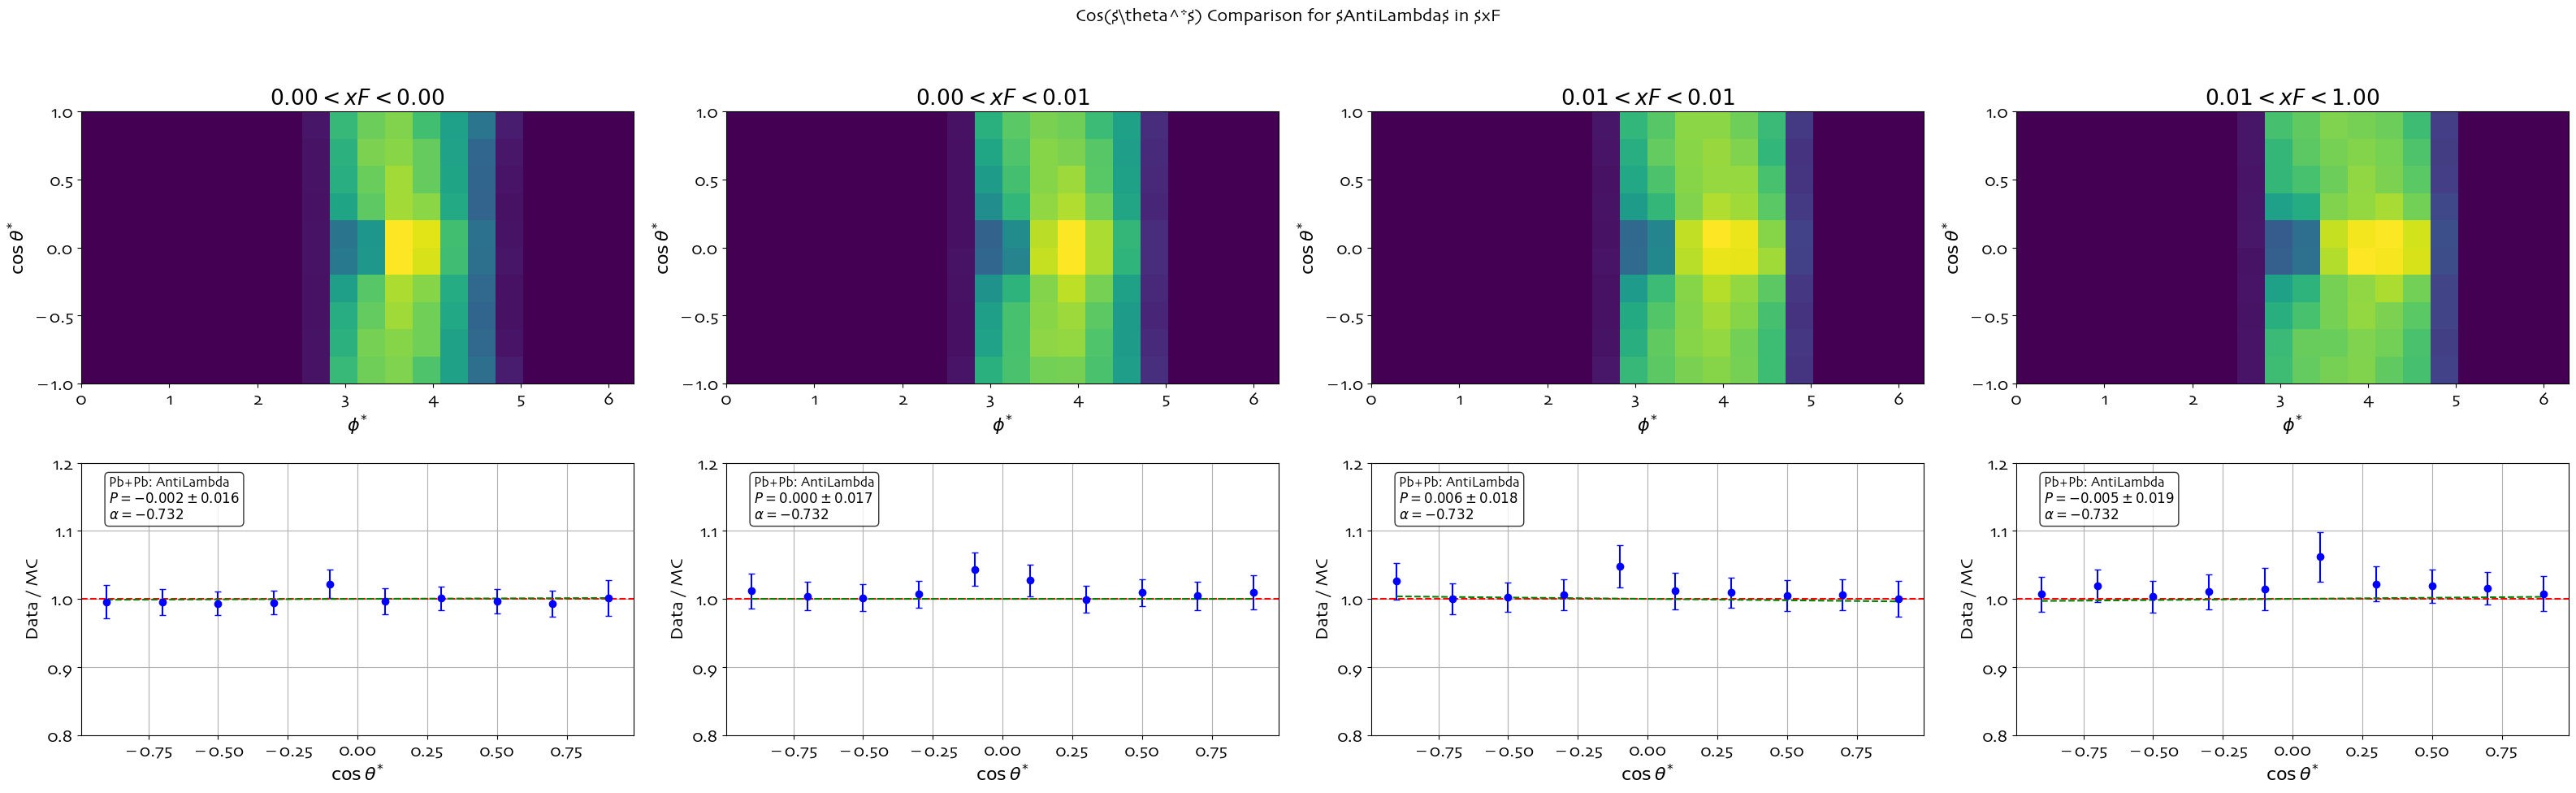

In [130]:

xf_results_2Dcorrection = MCcorrected2D_cos_theta_star_inBins(
    filename=path2rootFiles+make_filename('PbPb', 0),
    filename_mc=path2rootFiles+make_filename('PbPb', 1),
    pt_bins=xF_bins,
    BinsOfWhat='xF',
    hist_prefix="PhiStarCosThetaStar_",
    save_folder=save_folder,
    alpha_L0=alpha_L0,  # value of alpha for Λ
    system='Pb+Pb'
)

In [131]:
pt_centers_L_2Dcorr  = [r[0] for r in xf_results_2Dcorrection[1]]
P_L_2Dcorr           = [r[1] for r in xf_results_2Dcorrection[1]]
P_err_L_2Dcorr       = [r[2] for r in xf_results_2Dcorrection[1]]
pt_widths_L_2Dcorr   = [r[3] for r in xf_results_2Dcorrection[1]]

pt_centers_aL_2Dcorr  = [r[0] for r in xf_results_2Dcorrection[0]]
P_aL_2Dcorr           = [r[1] for r in xf_results_2Dcorrection[0]]
P_err_aL_2Dcorr       = [r[2] for r in xf_results_2Dcorrection[0]]
pt_widths_aL_2Dcorr   = [r[3] for r in xf_results_2Dcorrection[0]]



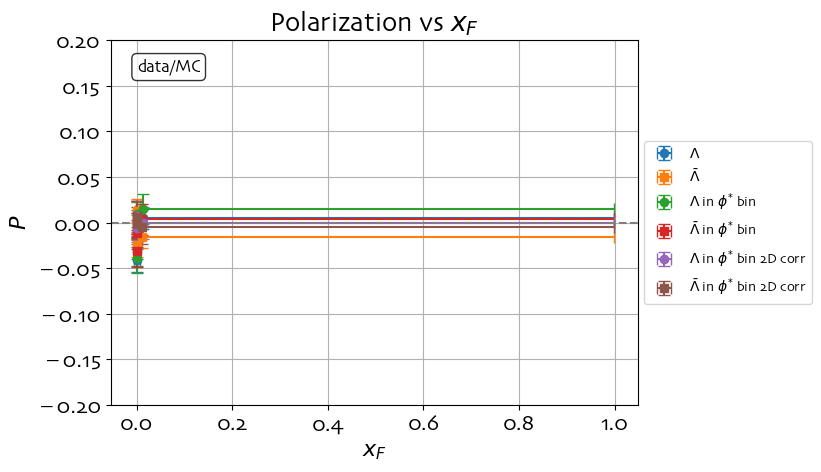

In [135]:
fig, ax = plt.subplots(figsize=(10, 5))

# Plot polarization values with error bars
ax.errorbar(xf_centers_l0, P_L, xerr=xerr_L, yerr=P_err_L, fmt='o', label=r'$\Lambda$', capsize=4)
ax.errorbar(xf_centers_al0, P_aL, xerr=xerr_aL, yerr=P_err_aL, fmt='s', label=r'$\bar{\Lambda}$', capsize=4)
ax.errorbar(xf_centers_l0, phi_P_L, xerr=xerr_L, yerr=phi_P_err_L, fmt='o', label=r'$\Lambda$ in $\phi^{*}$ bin', capsize=4)
ax.errorbar(xf_centers_al0, phi_P_aL, xerr=xerr_aL, yerr=phi_P_err_aL, fmt='s', label=r'$\bar{\Lambda}$ in $\phi^{*}$ bin', capsize=4)
ax.errorbar(xf_centers_l0, P_L_2Dcorr, xerr=xerr_L, yerr=P_err_L_2Dcorr, fmt='o', label=r'$\Lambda$ in $\phi^{*}$ bin 2D corr', capsize=4)
ax.errorbar(xf_centers_al0, P_aL_2Dcorr, xerr=xerr_aL, yerr=P_err_aL_2Dcorr, fmt='s', label=r'$\bar{\Lambda}$ in $\phi^{*}$ bin 2D corr', capsize=4)

# Plot horizontal reference line
ax.axhline(0, color='gray', linestyle='--')

# Labels and title
ax.set_xlabel(r'$x_F$')
ax.set_ylabel(r'$P$')
ax.set_title('Polarization vs $x_F$')
ax.set_ylim(-0.2, 0.2)
#ax.set_xlim(-0.25, 0.15)
ax.grid(True)

# Move legend to the right of the plot
ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), fontsize=10)

# Add text box in axes coordinates
ax.text(0.05, 0.95, 'data/MC',
        transform=ax.transAxes,
        fontsize=12,
        verticalalignment='top',
        bbox=dict(boxstyle="round", facecolor='white', alpha=0.8))

# Adjust layout to make room for legend
plt.tight_layout(rect=[0, 0, 0.85, 1])  # leave space on the right

# Save and show
plt.savefig("PLOTS_PbPb/Comparison_Polarization_vs_xF_MCcorrected2D.pdf")
plt.show()

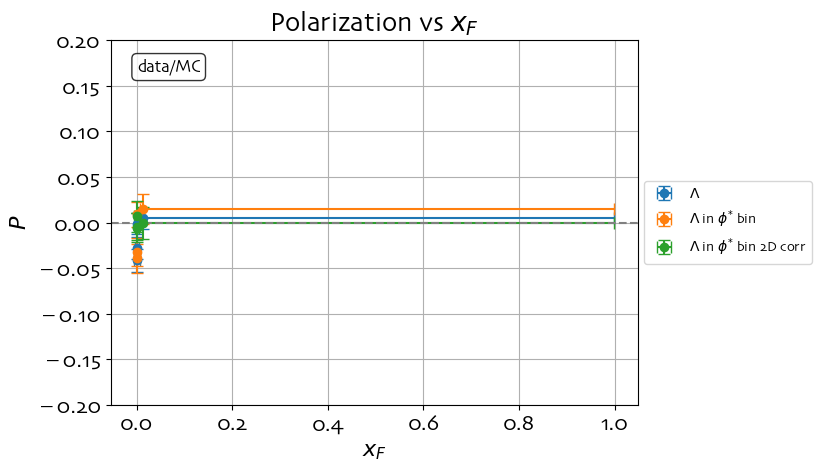

In [136]:
fig, ax = plt.subplots(figsize=(10, 5))

# Plot polarization values with error bars
ax.errorbar(xf_centers_l0, P_L, xerr=xerr_L, yerr=P_err_L, fmt='o', label=r'$\Lambda$', capsize=4)
#ax.errorbar(pt_centers_aL, P_aL, xerr=pt_widths_aL, yerr=P_err_aL, fmt='s', label=r'$\bar{\Lambda}$', capsize=4)
ax.errorbar(xf_centers_l0, phi_P_L, xerr=xerr_L, yerr=phi_P_err_L, fmt='o', label=r'$\Lambda$ in $\phi^{*}$ bin', capsize=4)
#ax.errorbar(phi_pt_centers_aL, phi_P_aL, xerr=phi_pt_widths_aL, yerr=phi_P_err_aL, fmt='s', label=r'$\bar{\Lambda}$ in $\phi^{*}$ bin', capsize=4)
ax.errorbar(xf_centers_l0, P_L_2Dcorr, xerr=xerr_L, yerr=P_err_L_2Dcorr, fmt='o', label=r'$\Lambda$ in $\phi^{*}$ bin 2D corr', capsize=4)
#ax.errorbar(pt_centers_aL_2Dcorr, P_aL_2Dcorr, xerr=phi_pt_widths_aL, yerr=P_err_aL_2Dcorr, fmt='s', label=r'$\bar{\Lambda}$ in $\phi^{*}$ bin 2D corr', capsize=4)

# Plot horizontal reference line
ax.axhline(0, color='gray', linestyle='--')

# Labels and title
ax.set_xlabel(r'$x_F$')
ax.set_ylabel(r'$P$')
ax.set_title('Polarization vs $x_F$')
ax.set_ylim(-0.2, 0.2)
#ax.set_xlim(-0.25, 0.15)
ax.grid(True)

# Move legend to the right of the plot
ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), fontsize=10)

# Add text box in axes coordinates
ax.text(0.05, 0.95, 'data/MC',
        transform=ax.transAxes,
        fontsize=12,
        verticalalignment='top',
        bbox=dict(boxstyle="round", facecolor='white', alpha=0.8))

# Adjust layout to make room for legend
plt.tight_layout(rect=[0, 0, 0.85, 1])  # leave space on the right

# Save and show
plt.savefig("PLOTS_PbPb/Comparison_Polarization_vs_xF_MCcorrected2D_L0.pdf")
plt.show()

[np.float64(0.001), 0, 0, np.float64(0.01167950134243204)]


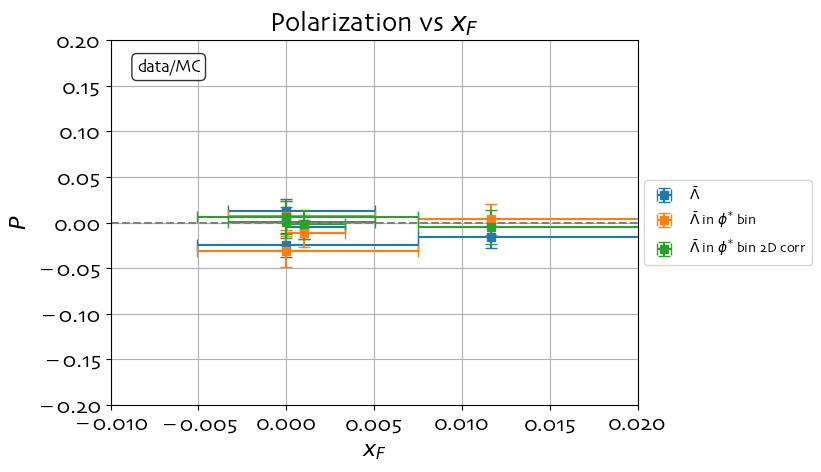

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))

# Plot polarization values with error bars
#ax.errorbar(pt_centers_L, P_L, xerr=pt_widths_L, yerr=P_err_L, fmt='o', label=r'$\Lambda$', capsize=4)
ax.errorbar(xf_centers_al0, P_aL, xerr=xerr_aL, yerr=P_err_aL, fmt='s', label=r'$\bar{\Lambda}$', capsize=4)
#ax.errorbar(phi_pt_centers_L, phi_P_L, xerr=phi_pt_widths_L, yerr=phi_P_err_L, fmt='o', label=r'$\Lambda$ in $\phi^{*}$ bin', capsize=4)
ax.errorbar(xf_centers_al0, phi_P_aL, xerr=xerr_aL, yerr=phi_P_err_aL, fmt='s', label=r'$\bar{\Lambda}$ in $\phi^{*}$ bin', capsize=4)
#ax.errorbar(pt_centers_L_2Dcorr, P_L_2Dcorr, xerr=pt_widths_L_2Dcorr, yerr=P_err_L_2Dcorr, fmt='o', label=r'$\Lambda$ in $\phi^{*}$ bin 2D corr', capsize=4)
ax.errorbar(xf_centers_al0, P_aL_2Dcorr, xerr=xerr_aL, yerr=P_err_aL_2Dcorr, fmt='s', label=r'$\bar{\Lambda}$ in $\phi^{*}$ bin 2D corr', capsize=4)

# Plot horizontal reference line
ax.axhline(0, color='gray', linestyle='--')

# Labels and title
ax.set_xlabel(r'$x_F$')
ax.set_ylabel(r'$P$')
ax.set_title('Polarization vs $x_F$')
ax.set_ylim(-0.2, 0.2)
ax.set_xlim(-0.01, 0.02)
ax.grid(True)

# Move legend to the right of the plot
ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), fontsize=10)

# Add text box in axes coordinates
ax.text(0.05, 0.95, 'data/MC',
        transform=ax.transAxes,
        fontsize=12,
        verticalalignment='top',
        bbox=dict(boxstyle="round", facecolor='white', alpha=0.8))

# Adjust layout to make room for legend
plt.tight_layout(rect=[0, 0, 0.85, 1])  # leave space on the right

# Save and show
plt.savefig("PLOTS_PbPb/Comparison_Polarization_vs_xF_MCcorrected2D_aL0.pdf")
plt.show()